<h1><center>Customer Churn Analysis and Prediction</center></h1>

<h2><center>Exploratory Data Analysis, Statistical Testing and Model Building</center></h2>

# Table of Contents

* [1. Introduction ](#1)
  * [1.1 Insights & Summary](#1.1)
* [2. Libraries & Configurations ](#2)
  * [2.1 Import Libraries](#2.1)
  * [2.2 Configurations](#2.2)
* [3 Descriptive Analysis](#3)
  * [3.1 Checking Duplicates](#3.1)
  * [3.2 Summary of Categorical Features](#3.2)
  * [3.3 Unique Values](#3.3)
* [4 Data Wrangling ](#4)
  * [4.1 Missing Values](#4.1)
    * [4.1.1 Change Data Type](#4.1.1)
    * [4.1.2 Imputation](#4.1.2)
  * [4.2 Binning](#4.2)
    * [4.2.1 Tenure](#4.2.1)
    * [4.2.2 MonthlyCharges](#4.2.2)
    * [4.2.3 TotalCharges](#4.2.3)
* [5 Univariate Analysis](#5)
  * [5.1 Statistical Normality Tests](#5.1)
    * [5.1.1 D’Agostino’s K^2 Test](#5.1.1)
    * [5.1.2 Anderson-Darling Test](#5.1.2)
  * [5.2 Visualization](#5.2)
* [6 Bivariate Analysis](#6)
  * [6.1 List Feature Based on Types](#6.1)
  * [6.2 Numerical & Numerical](#6.2)
      * [6.2.1 Spearman rank-order correlation](#6.2.1)
  * [6.3 Numerical & Categorical](#6.3)
    * [6.3.1 Kendall rank correlation coefficient](#6.3.1)
    * [6.3.2 Mann-Whitney U Test](#6.3.2)
    * [6.3.3 Polytomous(Nominal) with numeric](#6.3.3)
  * [6.4 Dichotomous & Dichotomous](#6.4)
    * [6.4.1 Phi’s correlation](#6.4.1)
  * [6.5 Categorical & categorical](#6.5)
    * [6.5.1 Chi-Square](#6.5.1)
    * [6.5.2 Cramér’s V](#6.5.2)
    * [6.5.3 Uncertainty Coefficient](#6.5.3)
  * [6.6 Collinearity](#6.6)
    * [6.6.1 Chi-Square](#6.6.1)
  * [6.7 Visualization](#6.7)
* [7 Multivariate Analysis](#7)
  * [7.1 Multicollinearity (Kruskal–Wallis)](#7.1)
  * [7.2 Frequency Distribution](#7.2)
  * [7.3 Churn Count Distribution](#7.3)
    * [7.3.1 Features With Cardinality = 2](#7.3.1)
    * [7.3.2 Features With Cardinality = 3](#7.3.2)
* [8 Save Cleaned Dataset](#8)
* [9 Conclusion](#9)
* [10 References](#10)

<a id='1'></a>
# 1 Introduction

The objective of this project is to present an extensive analysis of the **Customer Churn Dataset** and to predict the customer churn rate. The project is divided into two parts. The first part will focus on the statistical exploration of the dataset and the other part will demonstrate stacking ensemble model building with **XGBoost**, **Catboost** and **LightGBM** along with hyperparameter optimization using Optuna.


Dataset Source :

* [Kaggle Dataset URL](https://www.kaggle.com/blastchar/telco-customer-churn)
* [GitHub Dataset URL](https://raw.githubusercontent.com/shreya227/Telecom-Customer-Churn-Prediction/main/Telco-Customer-Churn-Original%20Dataset.csv)

You can also :
* Check the **GitHub Project Repository**

[![](https://img.shields.io/badge/Customer%20Churn%20Prediction-GitHub-100000?logo=github&logoColor=white)](https://github.com/shreya227/Telecom-Customer-Churn-Prediction/tree/main)


<a id='1.1'></a>

## 1.1 Insights & Summary

* Dataset mostly has categorical variables
* Performed statistical hypothesis test based on data types to check normality, correlation and multicollinearity
* Performed nonparametric statistical tests for the features which are not normally distributed
* All statistical tests were performed with a 95% confidence level (i.e., p value < 0.05)

<a id='2'></a>
# 2 Libraries & Configurations

<a id='2.1'></a>
## 2.1 Import Libraries

In [ ]:
"""Import basic modules"""
import math
import os
import gc
import random
import pprint
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns

# Warning Libraries
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter
from scipy import stats                         # For statistics
from scipy.stats.contingency import association # upgrade scipy to use this to calculate Cramer's V

"""Plotly visualization"""
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot


"""scikit-learn modules"""
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PowerTransformer # convert to Gaussian-like data
from sklearn.feature_selection import chi2
from sklearn.metrics import matthews_corrcoef

import multiprocessing
import pickle, joblib


from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))


sns.set_style('whitegrid')

init_notebook_mode(connected=True) # to display plotly graph offline

%matplotlib inline

In [ ]:
# customize as needed
plt_params = {
    # 'figure.facecolor': 'white',
    'axes.facecolor' : 'white',

    ## to set size
    # 'legend.fontsize': 'x-large',
    # 'figure.figsize': (15, 10),
    # 'axes.labelsize': 'x-large',
    # 'axes.titlesize': 'x-large',
    # 'xtick.labelsize': 'x-large',
    # 'ytick.labelsize': 'x-large'
}

plt.rcParams.update(plt_params)

<a id='2.2'></a>
## 2.2 Configurations

In [ ]:
# padding value to print left padded string
left_padding = 21

# seed value
SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

<a id='3'></a>
# 3 Descriptive Analysis

<table>
<thead><tr>
<th><strong>Feature Name</strong></th>
<th><strong>Description</strong></th>
<th><strong>Data Type</strong></th>
</tr>
</thead>
<tbody>
<tr>
<td>customerID</td>
<td>Contains customer ID</td>
<td>categorical</td>
</tr>
<tr>
<td>gender</td>
<td>whether the customer female or male</td>
<td>categorical</td>
</tr>
<tr>
<td>SeniorCitizen</td>
<td>Whether the customer is a senior citizen or not (1, 0)</td>
<td>numeric, int</td>
</tr>
<tr>
<td>Partner</td>
<td>Whether the customer has a partner or not (Yes, No)</td>
<td>categorical</td>
</tr>
<tr>
<td>Dependents</td>
<td>Whether the customer has dependents or not (Yes, No)</td>
<td>categorical</td>
</tr>
<tr>
<td>tenure</td>
<td>Number of months the customer has stayed with the company</td>
<td>numeric, int</td>
</tr>
<tr>
<td>PhoneService</td>
<td>Whether the customer has a phone service or not (Yes, No)</td>
<td>categorical</td>
</tr>
<tr>
<td>MultipleLines</td>
<td>Whether the customer has multiple lines r not (Yes, No, No phone service)</td>
<td>categorical</td>
</tr>
<tr>
<td>InternetService</td>
<td>Customer’s internet service provider (DSL, Fiber optic, No)</td>
<td>categorical</td>
</tr>
<tr>
<td>OnlineSecurity</td>
<td>Whether the customer has online security or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>OnlineBackup</td>
<td>Whether the customer has online backup or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>DeviceProtection</td>
<td>Whether the customer has device protection or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>TechSupport</td>
<td>Whether the customer has tech support or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>streamingTV</td>
<td>Whether the customer has streaming TV or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>streamingMovies</td>
<td>Whether the customer has streaming movies or not (Yes, No, No internet service)</td>
<td>categorical</td>
</tr>
<tr>
<td>Contract</td>
<td>The contract term of the customer (Month-to-month, One year, Two year)</td>
<td>categorical</td>
</tr>
<tr>
<td>PaperlessBilling</td>
<td>Whether the customer has paperless billing or not (Yes, No)</td>
<td>categorical</td>
</tr>
<tr>
<td>PaymentMethod</td>
<td>The customer’s payment method (Electronic check, Mailed check, Bank transfer, Credit card)</td>
<td>categorical</td>
</tr>
<tr>
<td>MonthlyCharges</td>
<td>The amount charged to the customer monthly </td>
<td> numeric , int</td>
</tr>
<tr>
<td>TotalCharges</td>
<td>The total amount charged to the customer </td>
<td>object</td>
</tr>
<tr>
<td>Churn</td>
<td>Whether the customer churned or not (Yes or No)</td>
<td>categorical</td>
</tr>
</tbody>
</table>

In [ ]:
df_churn = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df_churn.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
printmd(f"Dataset Dimension: **{df_churn.shape[0]}** rows,  **{df_churn.shape[1]}** columns")

Dataset Dimension: **7043** rows,  **21** columns

In [ ]:
df_churn.info()

printmd("<br>**SeniorCitizen** is already in integer form<br><br>**TotalCharges** should be converted to float")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<br>**SeniorCitizen** is already in integer form<br><br>**TotalCharges** should be converted to float

<a id='3.1'></a>
## 3.1 Checking Duplicates

In [ ]:
print('Known observations: {}\nUnique observations: {}'.format(len(df_churn.index),len(df_churn.drop_duplicates().index)))

printmd("**No duplicates Found!**")

Known observations: 7043
Unique observations: 7043


**No duplicates Found!**

#### Drop **customerID** column

In [ ]:
del df_churn["customerID"]

<a id='3.2'></a>
## 3.2 Summary of Categorical Features

In [ ]:
df_churn.describe(include=['object']).T

count unique               top  freq
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
TotalCharges      7043   6531                      11
Churn             7043      2                No  5174

<a id='3.3'></a>
## 3.3 Unique Values

In [ ]:
printmd("**Unique Values By Features**")
for feature in df_churn.columns:
    uniq = np.unique(df_churn[feature])
    print(feature.ljust(left_padding),len(uniq))

**Unique Values By Features**

gender                2
SeniorCitizen         2
Partner               2
Dependents            2
tenure                73
PhoneService          2
MultipleLines         3
InternetService       3
OnlineSecurity        3
OnlineBackup          3
DeviceProtection      3
TechSupport           3
StreamingTV           3
StreamingMovies       3
Contract              3
PaperlessBilling      2
PaymentMethod         4
MonthlyCharges        1585
TotalCharges          6531
Churn                 2


<a id='4'></a>
# 4 Data Wrangling

<a id='4.1'></a>
## 4.1 Missing Values

In [ ]:
df_churn.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
cat_cols = set(df_churn.columns) - set(df_churn._get_numeric_data().columns)

printmd("'**isna**' is only applicable for numerical data type<br>")
printmd("Checking missing values for object data type<br><br>")

for cat in cat_cols:
    print(cat.ljust(left_padding), df_churn[cat].apply(lambda x:len(x.strip()) == 0 or x.strip().lower() == 'nan').sum())

printmd("<br>TotalCharges is an object datatype, it has **11** 'nan' value")

'**isna**' is only applicable for numerical data type<br>

Checking missing values for object data type<br><br>

PaperlessBilling      0
StreamingMovies       0
PaymentMethod         0
InternetService       0
OnlineBackup          0
TotalCharges          11
Partner               0
Churn                 0
DeviceProtection      0
StreamingTV           0
Dependents            0
TechSupport           0
OnlineSecurity        0
PhoneService          0
gender                0
Contract              0
MultipleLines         0


<br>TotalCharges is an object datatype, it has **11** 'nan' value

<a id='4.1.1'></a>
### 4.1.1 Change Data Type

Convert **TotalCharges** to numeric

In [ ]:
df_churn["TotalCharges"] = pd.to_numeric(df_churn["TotalCharges"], errors = 'coerce')

<a id='4.1.2'></a>

### 4.1.2 Imputation

In [ ]:
indices_null_tc = df_churn[df_churn["TotalCharges"].isna()].index

In [ ]:
display(df_churn.iloc[indices_null_tc])

printmd("<br>**'Tenure' (months stayed at the company) is correlated with 'TotalCharges' column**")
printmd("**when 'Tenure' is 0 , 'TotalCharges' is 0 too**")

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)           52.55           NaN    No  
753                Mailed check           20.25           NaN    No  
936                Mailed check           80.85           NaN    No  
1082               Mailed check           25.75           NaN    No  
1340    Credit card (automatic)           56.05           NaN    No  
3331               Mailed check           19.85           NaN    No  
3826               Mailed check           25.35           NaN    No  
4380               Mailed check           20.00           

<br>**'Tenure' (months stayed at the company) is correlated with 'TotalCharges' column**

**when 'Tenure' is 0 , 'TotalCharges' is 0 too**

In [ ]:
display(df_churn[df_churn.tenure == 1].head(2))

printmd("<br>**'TotalCharges' is the same as 'MonthlyCharges' when 'Tenure' is not 0**")

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0   Female              0     Yes         No       1           No   
20    Male              1      No         No       1           No   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
0   No phone service             DSL             No          Yes   
20  No phone service             DSL             No           No   

   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                No          No          No              No  Month-to-month   
20              Yes          No          No             Yes  Month-to-month   

   PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges Churn  
0               Yes  Electronic check           29.85         29.85    No  
20              Yes  Electronic check           39.65         39.65   Yes

<br>**'TotalCharges' is the same as 'MonthlyCharges' when 'Tenure' is not 0**

In [ ]:
display(df_churn[df_churn.tenure == 3].head(2))

printmd("<br>**'TotalCharges' increases with respect to 'MonthlyCharges' and 'Tenure'**")
printmd("<br>From the above observation we can conclude that, **'TotalCharges'  = 'MonthlyCharges' x 'Tenure' + Extra Cost**")
printmd("**Therefore, imputing missing values on 'TotalCharges' column with 0**")

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
65  Female              0      No         No       3          Yes   
74  Female              0      No        Yes       3          Yes   

   MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
65            No             DSL             No          Yes               No   
74            No             DSL            Yes           No               No   

   TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
65         Yes         Yes             Yes  Month-to-month              Yes   
74         Yes          No             Yes  Month-to-month              Yes   

                PaymentMethod  MonthlyCharges  TotalCharges Churn  
65           Electronic check            75.3         244.1    No  
74  Bank transfer (automatic)            64.5         177.4    No

<br>**'TotalCharges' increases with respect to 'MonthlyCharges' and 'Tenure'**

<br>From the above observation we can conclude that, **'TotalCharges'  = 'MonthlyCharges' x 'Tenure' + Extra Cost**

**Therefore, imputing missing values on 'TotalCharges' column with 0**

In [ ]:
df_churn['TotalCharges'].fillna(0, inplace=True)

In [ ]:
df_churn[['tenure', 'MonthlyCharges', 'TotalCharges']].describe().T

count         mean          std    min     25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.00    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.35   
TotalCharges    7043.0  2279.734304  2266.794470   0.00  398.55  1394.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80

<a id='4.2'></a>
## 4.2 Binning

There are three numerical data types which can be ranked based on their values :

* Tenure, MonthlyCharges and TotalCharges

We can bin them into three levels : **high, medium and low**

In [ ]:
def binning_feature(feature):
    plt.hist(df_churn[feature])

    # set x/y labels and plot title
    plt.xlabel(f"{feature.title()}")
    plt.ylabel("Count")
    plt.title(f"{feature.title()} Bins")
    plt.show()

    bins = np.linspace(min(df_churn[feature]), max(df_churn[feature]), 4)

    printmd("**Value Range**")

    printmd(f"Low ({bins[0] : .2f} - {bins[1]: .2f})")
    printmd(f"Medium ({bins[1]: .2f} - {bins[2]: .2f})")
    printmd(f"High ({bins[2]: .2f} - {bins[3]: .2f})")

    group_names = ['Low', 'Medium', 'High']

    df_churn.insert(df_churn.shape[1]-1,f'{feature}-binned', pd.cut(df_churn[feature], bins, labels=group_names, include_lowest=True))
    display(df_churn[[feature, f'{feature}-binned']].head(10))


    # count values
    printmd("<br>**Binning Distribution**<br>")
    display(df_churn[f'{feature}-binned'].value_counts())


    # plot the distribution of each bin
    plt.bar(group_names, df_churn[f'{feature}-binned'].value_counts())
    # px.bar(data_canada, x='year', y='pop')

    # set x/y labels and plot title
    plt.xlabel(f"{feature.title()}")
    plt.ylabel("Count")
    plt.title(f"{feature.title()} Bins")
    plt.show()

<a id='4.2.1'></a>
### 4.2.1 Tenure

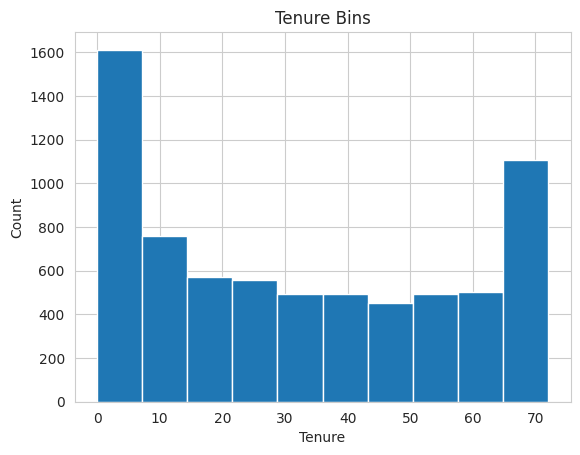

**Value Range**

Low ( 0.00 -  24.00)

Medium ( 24.00 -  48.00)

High ( 48.00 -  72.00)

tenure tenure-binned
0       1           Low
1      34        Medium
2       2           Low
3      45        Medium
4       2           Low
5       8           Low
6      22           Low
7      10           Low
8      28        Medium
9      62          High

<br>**Binning Distribution**<br>

tenure-binned
Low       3210
High      2239
Medium    1594
Name: count, dtype: int64

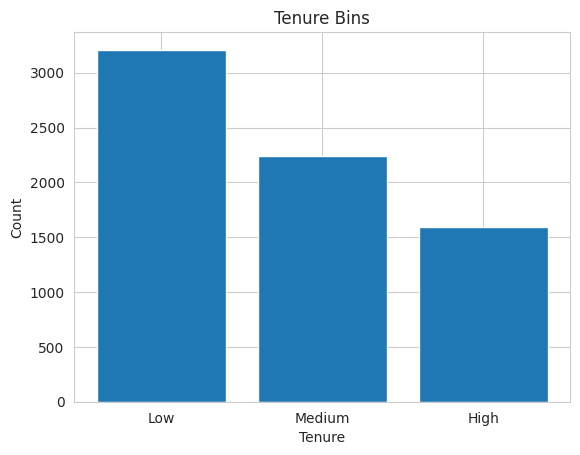

In [ ]:
binning_feature('tenure')

<a id='4.2.2'></a>
### 4.2.2 MonthlyCharges

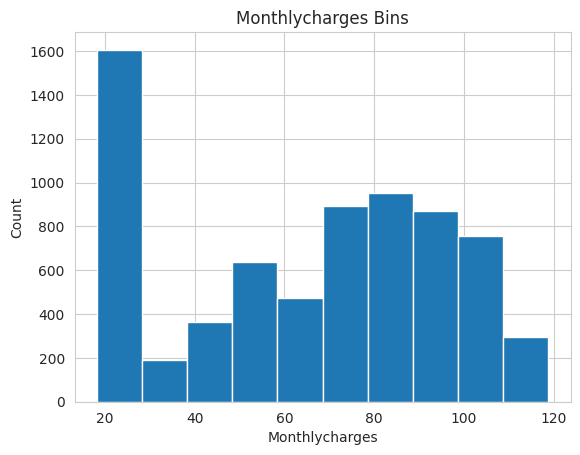

**Value Range**

Low ( 18.25 -  51.75)

Medium ( 51.75 -  85.25)

High ( 85.25 -  118.75)

MonthlyCharges MonthlyCharges-binned
0           29.85                   Low
1           56.95                Medium
2           53.85                Medium
3           42.30                   Low
4           70.70                Medium
5           99.65                  High
6           89.10                  High
7           29.75                   Low
8          104.80                  High
9           56.15                Medium

<br>**Binning Distribution**<br>

MonthlyCharges-binned
Low       2451
Medium    2439
High      2153
Name: count, dtype: int64

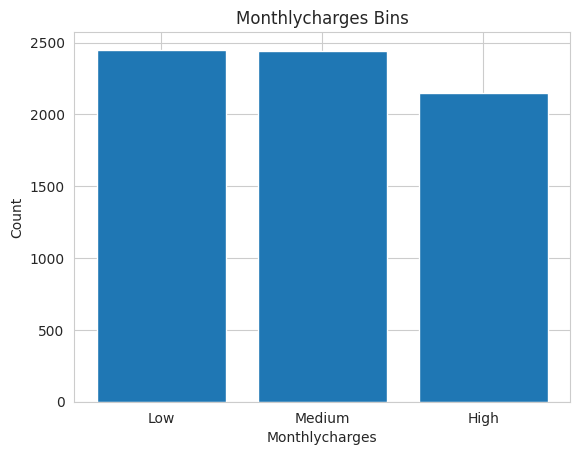

In [ ]:
binning_feature('MonthlyCharges')

<a id='4.2.3'></a>
### 4.2.3 TotalCharges

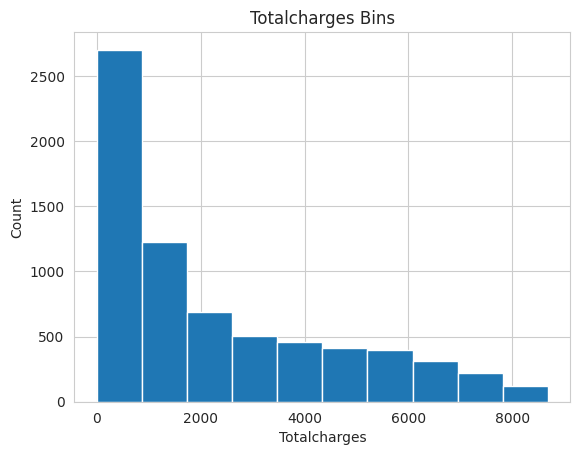

**Value Range**

Low ( 0.00 -  2894.93)

Medium ( 2894.93 -  5789.87)

High ( 5789.87 -  8684.80)

TotalCharges TotalCharges-binned
0         29.85                 Low
1       1889.50                 Low
2        108.15                 Low
3       1840.75                 Low
4        151.65                 Low
5        820.50                 Low
6       1949.40                 Low
7        301.90                 Low
8       3046.05              Medium
9       3487.95              Medium

<br>**Binning Distribution**<br>

TotalCharges-binned
Low       4782
Medium    1474
High       787
Name: count, dtype: int64

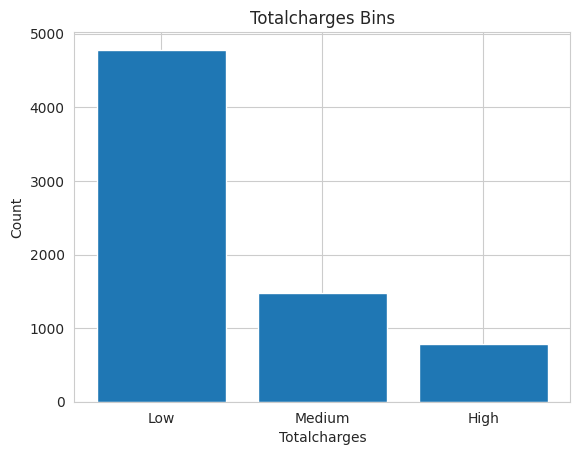

In [ ]:
binning_feature('TotalCharges')

**Data Types Distribution after cleaning**

In [ ]:
printmd("**Data Types**<br>")
df_churn.dtypes.value_counts()

**Data Types**<br>

object      16
category     3
int64        2
float64      2
Name: count, dtype: int64

<a id='5'></a>
# 5 Univariate Analysis

<a id='5.1'></a>
## 5.1 Statistical Normality Tests

Normality tests are used to determine if a dataset is normally distributed and to check how likely it is for a random variable in the dataset to be normally distributed.

Popular normality tests -  D’Agostino’s K^2, Shapiro-Wilk, Anderson-Darling .

There are three numerical features in this dataset - **MonthlyCharges**, **Tenure**, and **TotalCharges**.


Hypotheses -

* H0: the sample has a Gaussian distribution.
* H1: the sample does not have a Gaussian distribution.

NB : we can not perform **Shapiro-Wilk Test** because sample size > 5000 and for this test p-value may not be accurate for N > 5000

<a id='5.1.1'></a>
### 5.1.1 D’Agostino’s K^2 Test

#### MonthlyCharges

In [ ]:
stat, p = stats.normaltest(df_churn['MonthlyCharges'])

print('Statistics=%.5f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=11419.52879, p=0.000
Sample does not look Gaussian (reject H0)


#### Tenure

In [ ]:
stat, p = stats.normaltest(df_churn['tenure'])

print('Statistics=%.5f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=76258.50517, p=0.000
Sample does not look Gaussian (reject H0)


<a id='5.1.2'></a>
### 5.1.2 Anderson-Darling Test

`Critical values` in a statistical test are a range of pre-defined significance boundaries at which the H0 can be failed to be rejected if the calculated statistic is less than the critical value.

Rather than just a single p-value, this test returns a critical value for a **range of different commonly used significance levels**.

In this case  - **normal/exponential** (15%, 10%, 5%, 2.5%, 1%)

#### TotalCharges

In [ ]:
result = stats.anderson(df_churn['TotalCharges'])

print('Statistic: %.3f' % result.statistic)

p = 0

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print(f'Significance level {sl:.2f} % : critical value {cv:.3f}, data looks normal (fail to reject H0)')
    else:
        print(f'Significance level {sl:.2f} % : critical value {cv:.3f}, data does not look normal (reject H0)')

Statistic: 346.638
Significance level 15.00 % : critical value 0.576, data does not look normal (reject H0)
Significance level 10.00 % : critical value 0.656, data does not look normal (reject H0)
Significance level 5.00 % : critical value 0.787, data does not look normal (reject H0)
Significance level 2.50 % : critical value 0.917, data does not look normal (reject H0)
Significance level 1.00 % : critical value 1.091, data does not look normal (reject H0)


In [ ]:
df_churn.head(3)

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No  Month-to-month              Yes  Electronic check   
1              No        One year               No      Mailed check   
2              No  Month-to-month              Yes      Mailed check   

  MonthlyCharges TotalCharges tenure-binned  MonthlyCharges-binned  \
0          29.85        29.85           Low                    Low   
1          56.95      1889.50        Medium                 Medium   
2          53.85       108.15           Low                 Medium   

   TotalCharges-binned Churn  
0                  Low    No  
1                  Low    No  
2                  Low   Yes  

[3 rows x 23 columns]

<a id='5.2'></a>
## 5.2 Visualization

### Churn (Target) Distribution

In [ ]:
fig = px.pie(df_churn['Churn'].value_counts(), values='count', names='count', title='Churn (Target) Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="colab")
printmd("### Target distribution is Imbalanced")

### Target distribution is Imbalanced

### OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport`

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_churn['OnlineSecurity'].value_counts().index, values=df_churn['OnlineSecurity'].value_counts().values, name="Online Security"),
              1, 1)
fig.add_trace(go.Pie(labels=df_churn['OnlineBackup'].value_counts().index, values=df_churn['OnlineBackup'].value_counts().values, name="Online Backup"),
              1, 2)
fig.add_trace(go.Pie(labels=df_churn['DeviceProtection'].value_counts().index, values=df_churn['DeviceProtection'].value_counts().values, name="Device Protection"),
              2, 1)
fig.add_trace(go.Pie(labels=df_churn['TechSupport'].value_counts().index, values=df_churn['TechSupport'].value_counts().values, name="Tech Support"),
              2, 2)

# donut-like pie chart
fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Online<br>Security', x=0.195, y=0.85, font_size=20, showarrow=False),
                 dict(text='Online<br>Backup', x=0.804, y=0.86, font_size=20, showarrow=False),
                 dict(text='Device<br>Protection', x=0.192, y=0.18, font_size=20, showarrow=False),
                 dict(text='Tech<br>Support', x=0.805, y=0.18, font_size=20, showarrow=False)])
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show(renderer="colab")



printmd("### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution")

### 'Online Backup', 'Device Protection' and 'Online Security', 'Tech Support' has similar distribution

### PaymentMethod

In [ ]:
payment_counts = df_churn.groupby('PaymentMethod').size().reset_index(name='count')

# Create the pie chart
fig = px.pie(payment_counts, values='count', names='PaymentMethod', title='Payment Method Distribution')

# Add legends
fig.update_traces(textposition='inside', textinfo='percent+label')

# Display the chart
fig.show(renderer="colab")

printmd("#### Majority of the customers use E-check")

#### Majority of the customers use E-check

### Gender

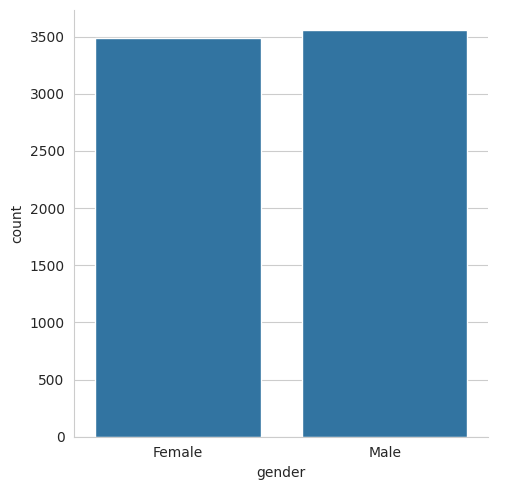

#### Approximately 50/50 gender ratio

In [ ]:
sns.catplot(x="gender", kind="count", data=df_churn)
plt.show()

printmd("#### Approximately 50/50 gender ratio")

### Dependents

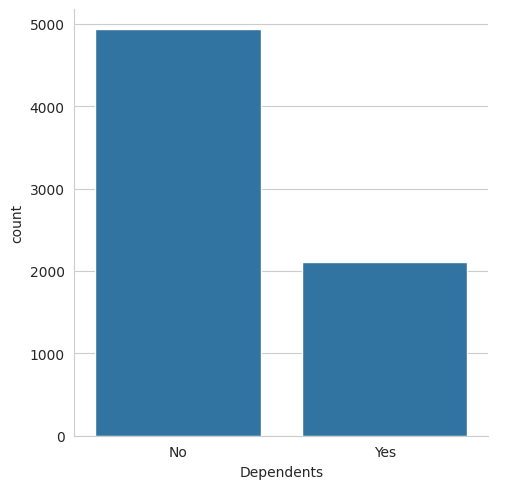

#### Users who have non-dependents are approximately two times more than users having dependents

In [ ]:
sns.catplot(x="Dependents", kind="count", data=df_churn)
plt.show()

printmd("#### Users who have non-dependents are approximately two times more than users having dependents")

### Senior Citizen

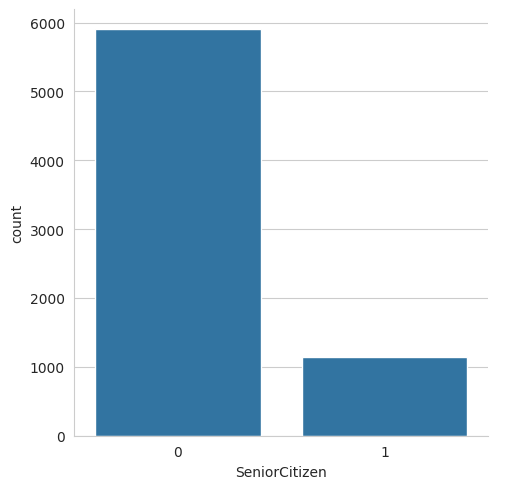

#### The majority of the users are not Senior Citizen

In [ ]:
sns.catplot(x="SeniorCitizen", kind="count", data=df_churn)
plt.show()

printmd("#### The majority of the users are not Senior Citizen")

### Contract

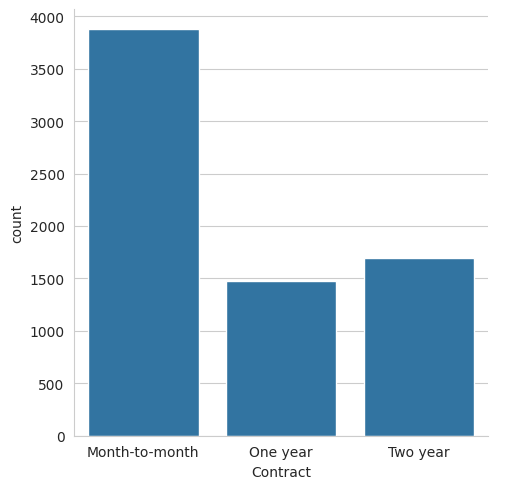

#### Most of the users prefer Month-to-month contract

In [ ]:
sns.catplot(x="Contract", kind="count", data=df_churn)
plt.show()

printmd("#### Most of the users prefer Month-to-month contract")

### PaperlessBilling

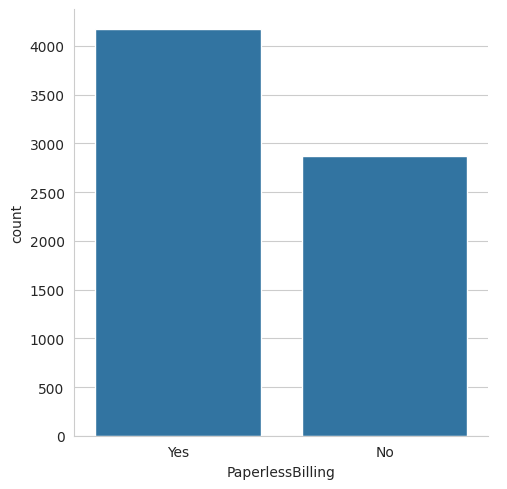

#### Most of the users prefer paperless billing

In [ ]:
sns.catplot(x="PaperlessBilling", kind="count", data=df_churn)
plt.show()

printmd("#### Most of the users prefer paperless billing")

### Total Charges

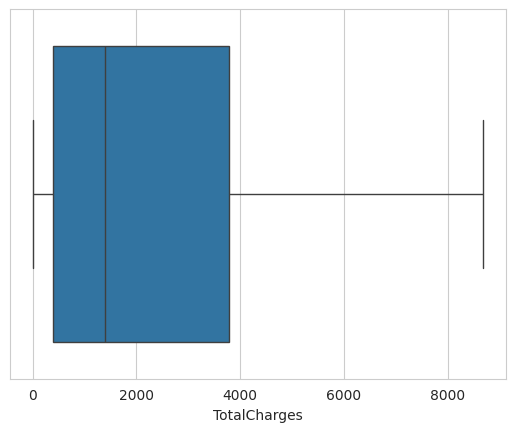

#### The total charges fall under 4000 for majority of the users

In [ ]:
sns.boxplot(x=df_churn["TotalCharges"])
plt.show()

printmd("#### The total charges fall under 4000 for majority of the users.")

### Numerical Features

In [ ]:
"""#1.Create a function to plot histogram and density plot."""
def plot_histogram(feature):
    """Plots histogram and density plot of a variable."""

    # Create subplot object
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"Distribution of {feature.name} with Histogram", f"Distribution of {feature.name} with Density Plot"))

    # This is a count histogram
    fig.add_trace(
        go.Histogram(
            x = feature,
            hoverinfo="x+y"
        ),
    row=1,col=1)

    # This is a density histogram
    fig.add_trace(
        go.Histogram(
            x = feature,
            hoverinfo="x+y",
            histnorm = "density"
        ),
    row=2,col=1)

    # Update layout
    fig.layout.update(
        height=800,
        width=870,
        hovermode="closest"
        )

    # Update axes
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Density(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{feature.name}</b>")
    return fig.show(renderer="colab")

In [ ]:
plot_histogram(df_churn['tenure'])

printmd("**Tenure is U-shaped distributed**")

**Tenure is U-shaped distributed**

In [ ]:
plot_histogram(df_churn['MonthlyCharges'])

printmd("**MonthlyCharges is heavily skewed**")

**MonthlyCharges is heavily skewed**

In [ ]:
plot_histogram(df_churn['TotalCharges'])

printmd("**TotalCharges is reversed J-shaped distributed**")

**TotalCharges is reversed J-shaped distributed**

<a id='6'></a>
# 6 Bivariate Analysis

In this section, I did an extensive statistical analysis with various hypotheses testing based on paired data types -

* numerical and numerical data
* numerical and ordinal data
* ordinal and ordinal data
* categorical and categorical data


#### General Hypotheses -

* **H0: the two samples are independent**
* **H1: there is a dependency between the samples**

<a id='6.1'></a>
## 6.1 List Feature Based on Types

In [ ]:
# Check cardinality of categorical variables
target_col_filter = df_churn.loc[:, df_churn.columns != 'Churn']


cat_cols = list(set(target_col_filter.columns) - set(target_col_filter._get_numeric_data().columns))
num_cols = list(set(target_col_filter._get_numeric_data().columns) - set({'SeniorCitizen'})) # already converted to integer


# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: target_col_filter[col].nunique(), cat_cols))
dict_features_by_col = dict(zip(cat_cols, object_nunique))


# Print number of unique entries by column, in ascending order
print(sorted(dict_features_by_col.items(), key=lambda x: x[1]))


ordinal_cols = ['tenure-binned', 'MonthlyCharges-binned', 'TotalCharges-binned']
dichotomous_cols = [cat for cat in cat_cols if df_churn[cat].value_counts().count() == 2]
polytomous_cols = list(set(cat_cols) - set(dichotomous_cols) - set(ordinal_cols))


print("Categorical Columns".ljust(left_padding), cat_cols)

print("Numerical Columns".ljust(left_padding), num_cols)

print("Ordinal Columns".ljust(left_padding), ordinal_cols)

print("Dichotomous Columns".ljust(left_padding), dichotomous_cols)

print("Polytomous Columns".ljust(left_padding), polytomous_cols)


[('PaperlessBilling', 2), ('Partner', 2), ('Dependents', 2), ('PhoneService', 2), ('gender', 2), ('MonthlyCharges-binned', 3), ('StreamingMovies', 3), ('InternetService', 3), ('OnlineBackup', 3), ('TotalCharges-binned', 3), ('DeviceProtection', 3), ('StreamingTV', 3), ('tenure-binned', 3), ('TechSupport', 3), ('OnlineSecurity', 3), ('Contract', 3), ('MultipleLines', 3), ('PaymentMethod', 4)]
Categorical Columns   ['MonthlyCharges-binned', 'PaperlessBilling', 'StreamingMovies', 'PaymentMethod', 'InternetService', 'OnlineBackup', 'Partner', 'TotalCharges-binned', 'DeviceProtection', 'StreamingTV', 'Dependents', 'tenure-binned', 'TechSupport', 'OnlineSecurity', 'PhoneService', 'gender', 'Contract', 'MultipleLines']
Numerical Columns     ['MonthlyCharges', 'TotalCharges', 'tenure']
Ordinal Columns       ['tenure-binned', 'MonthlyCharges-binned', 'TotalCharges-binned']
Dichotomous Columns   ['PaperlessBilling', 'Partner', 'Dependents', 'PhoneService', 'gender']
Polytomous Columns    ['Multi

**Categorical Columns**
> 'TechSupport', 'DeviceProtection', 'Contract', 'PaperlessBilling', 'TotalCharges-binned', <br>'gender', 'OnlineBackup', 'InternetService', 'StreamingTV', 'tenure-binned', <br>'Dependents', 'PhoneService', 'StreamingMovies', 'MultipleLines', 'Partner', <br>'MonthlyCharges-binned', 'OnlineSecurity', 'PaymentMethod'

**Numerical Columns**
> 'MonthlyCharges', 'tenure', 'TotalCharges'

**Ordinal Columns**
> tenure-binned', 'MonthlyCharges-binned', 'TotalCharges-binned'

**Dichotomous Columns**
> 'PaperlessBilling', 'gender', 'Dependents', 'PhoneService', 'Partner'

**Polytomous Columns**
> 'TechSupport', 'StreamingMovies', 'DeviceProtection', 'MultipleLines', 'Contract',<br> 'InternetService', 'OnlineSecurity', 'StreamingTV', 'PaymentMethod', 'OnlineBackup'

<a id='6.2'></a>
## 6.2 Numerical & Numerical

<a id='6.2.1'></a>
### 6.2.1 Spearman rank-order correlation
---
AKA Spearman's rho or Spearman correlation coefficient


Applied to **Continuous or ordinal** variable

<br>

For Pearson r correlation, both variables should be normally distributed
According to the normality test tenure, MonthlyCharges and TotalCharges columns are **not normally distributed**

**Unlike the Pearson correlation**, the Spearman correlation does not assume that both datasets are **normally distributed**

Pearson correlation assumes normality, linearity and homoscedasticity. Pearson's correlation is also unable to tell the difference between dependent and independent variables

Hypotheses -

* **H0: the two samples do not have monotonic relationship**
* **H1: there is a monotonic relationship between the samples**

In [ ]:
def cal_spearmanr(c1, c2):

    alpha = 0.05

    correlation, p_value = stats.spearmanr(df_churn[c1], df_churn[c2])

    print(f'{c1}, {c2} correlation : {correlation}, p : {p_value}')

    if p_value > alpha:
        print('Probably do not have monotonic relationship (fail to reject H0)')
    else:
        print('Probably have monotonic relationship (reject H0)')

In [ ]:
cal_spearmanr('tenure','MonthlyCharges')

tenure, MonthlyCharges correlation : 0.27641678933130215, p : 1.0271266876409408e-123
Probably have monotonic relationship (reject H0)


In [ ]:
cal_spearmanr('tenure','TotalCharges')

tenure, TotalCharges correlation : 0.8896957900597577, p : 0.0
Probably have monotonic relationship (reject H0)


In [ ]:
cal_spearmanr('MonthlyCharges','TotalCharges')

MonthlyCharges, TotalCharges correlation : 0.638028390201301, p : 0.0
Probably have monotonic relationship (reject H0)


<a id='6.3'></a>
## 6.3 Numerical & Categorical

<a id='6.3.1'></a>
### 6.3.1 Kendall rank correlation coefficient
---
AKA **Kendall's τ** or **Kendall's Tau**

Kendall’s Tau is often used for correlation on continuous data if there are outliers in the data

A τ test is a non-parametric hypothesis test for statistical dependence based on the τ coefficient

Variable would be **continuous or ordinal**

Ordinal variable examples -
* age, weight, height, test scores, survey scores, yearly salary, etc
* education level (GDE/Bachelors/Masters/PhD), income level (if grouped into high/medium/low) etc

In this dataset there are three ordinal features :
* **tenure-binned**
* **MonthlyCharges-binned**
* **TotalCharges-binned**

In [ ]:

def kendall_rank_correlation(feature1, feature2):

    coef, p_value = stats.kendalltau(df_churn[feature1], df_churn[feature2])
    print(f"Correlation between {feature1} and {feature2} ")
    print('Kendall correlation coefficient = %.5f, p = %.5f' % (coef, p_value))

    # interpret the significance
    alpha = 0.05
    if p_value > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p_value)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p_value)
    print('----\n')

In [ ]:
ordinal_features = ['tenure-binned','MonthlyCharges-binned', 'TotalCharges-binned']

for ord in ordinal_features:
    printmd(f"Correlation with **{ord}**")
    kendall_rank_correlation('tenure',ord)
    kendall_rank_correlation('MonthlyCharges',ord)
    kendall_rank_correlation('TotalCharges',ord)

Correlation with **tenure-binned**

Correlation between tenure and tenure-binned 
Kendall correlation coefficient = -0.28746, p = 0.00000
Samples are correlated (reject H0) p=0.000
----

Correlation between MonthlyCharges and tenure-binned 
Kendall correlation coefficient = -0.10710, p = 0.00000
Samples are correlated (reject H0) p=0.000
----

Correlation between TotalCharges and tenure-binned 
Kendall correlation coefficient = -0.23680, p = 0.00000
Samples are correlated (reject H0) p=0.000
----



Correlation with **MonthlyCharges-binned**

Correlation between tenure and MonthlyCharges-binned 
Kendall correlation coefficient = -0.16485, p = 0.00000
Samples are correlated (reject H0) p=0.000
----

Correlation between MonthlyCharges and MonthlyCharges-binned 
Kendall correlation coefficient = -0.22506, p = 0.00000
Samples are correlated (reject H0) p=0.000
----

Correlation between TotalCharges and MonthlyCharges-binned 
Kendall correlation coefficient = -0.20858, p = 0.00000
Samples are correlated (reject H0) p=0.000
----



Correlation with **TotalCharges-binned**

Correlation between tenure and TotalCharges-binned 
Kendall correlation coefficient = 0.07424, p = 0.00000
Samples are correlated (reject H0) p=0.000
----

Correlation between MonthlyCharges and TotalCharges-binned 
Kendall correlation coefficient = 0.00298, p = 0.75152
Samples are uncorrelated (fail to reject H0) p=0.752
----

Correlation between TotalCharges and TotalCharges-binned 
Kendall correlation coefficient = 0.12334, p = 0.00000
Samples are correlated (reject H0) p=0.000
----



<a id='6.3.2'></a>
### 6.3.2 Mann-Whitney U Test

The Mann-Whitney U test is a **nonparametric** statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

The test determines whether the medians of two or more groups are different.

**NB** : For the test to be effective, it requires **at least 20 observations** in each data sample.

* Fail to Reject H0: Sample distributions are equal. (or sample distributions are likely drawn from the same population)
* Reject H0: Sample distributions are not equal.

or

* **H0: population medians are equal**
* **H1: population medians are not equal**

### Correlation with Target (Dichotomous)

In [ ]:
def mannwhitneyu_correlation(feature1):
    stat, p_value = stats.mannwhitneyu(df_churn[feature1], (df_churn['Churn'] == 'Yes').astype(int))
    print(f"Correlation between {feature1} and Churn")
    print('Statistics = %.5f, p = %.5f' % (stat, p_value))

    # interpret the significance
    alpha = 0.05
    if p_value > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    print('----\n')

In [ ]:
numerical_features = ['tenure','MonthlyCharges', 'TotalCharges']

for num in numerical_features:
    printmd(f"Correlation with **{num}**")
    mannwhitneyu_correlation(num)

Correlation with **tenure**

Correlation between tenure and Churn
Statistics = 48981984.50000, p = 0.00000
Different distribution (reject H0)
----



Correlation with **MonthlyCharges**

Correlation between MonthlyCharges and Churn
Statistics = 49603849.00000, p = 0.00000
Different distribution (reject H0)
----



Correlation with **TotalCharges**

Correlation between TotalCharges and Churn
Statistics = 49554833.00000, p = 0.00000
Different distribution (reject H0)
----



**Biserial correlation**

The point biserial correlation is used to measure the relationship between a **binary variable, x, and a continuous variable, y**. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

NB: point-biserial correlation is conducted with the Pearson correlation formula except that one of the variables is dichotomous

The assumptions for Point-Biserial correlation include:

* Continuous and Binary
* **Normally Distributed** (In our case not normal)
* No Outliers
* Equal Variances

Options to normalize a non-normal distribution -

* Log transform
* Square root transform
* Box cox (can only be applied to strictly positive data)
* Yeo Johnson (both positive and negative)

In [ ]:
# https://stackoverflow.com/questions/53624804/how-to-normalize-a-non-normal-distribution

data = df_churn['MonthlyCharges'].to_numpy()
pt = PowerTransformer(method='yeo-johnson') # ‘box-cox’, 'yeo-johnson'
data = data.reshape(-1, 1)
pt.fit(data)
transformed_data = pt.transform(data)

transformed_k2, transformed_p = stats.normaltest(transformed_data)

# other methods to transform into gaussian distribution

# log transform
# stats.normaltest(np.log(df_churn['MonthlyCharges']))

# square transform
# stats.normaltest(np.sqrt(df_churn['MonthlyCharges'])

# box-cox transform
# stats.normaltest(stats.boxcox(df_churn['MonthlyCharges'])[0])

# all other methods failed to convert into gaussian


alpha = 0.05
if transformed_p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


**Since the numerical columns can not be converted to gaussian distribution, point biseral correlation test can not be performed**

<a id='6.3.3'></a>
### 6.3.3 Polytomous(Nominal) with numeric

For a dichotomous categorical variable and a continuous variable we can calculate a Pearson correlation if the categorical variable has a 0/1-coding for the categories. This correlation is then also known as a point-biserial correlation coefficient. (parametric test)

But when we have **more than two categories** for the categorical variable the Pearson correlation is not appropriate anymore.

We should then use **eta-squared, or eta**, as an effect-size measure for the relationship of a **categorical variable and a continuous variable**.


In [ ]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [ ]:
correlation_ratio(df_churn['PaymentMethod'], df_churn['MonthlyCharges'])

0.40127388087245935

In [ ]:
correlation_ratio(df_churn['PaymentMethod'], df_churn['TotalCharges'])

0.35074070554475645

In [ ]:
correlation_ratio(df_churn['PaymentMethod'], df_churn['tenure'])

0.3998293691962001

<a id='6.4'></a>
## 6.4 Dichotomous & Dichotomous

In classification, when both of the features are categorical, then the strength of the relationship between them can be measured using a **Chi-square test**

<a id='6.4.1'></a>
### 6.4.1 Phi’s correlation
---
The Matthews correlation coefficient (MCC) or phi coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications

View on Wikipedia :  **[Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)**


In [ ]:
printmd("**Correlation Between Dichotomous Features with Target : Churn**")

for col in dichotomous_cols:
    print(col.ljust(left_padding), matthews_corrcoef(df_churn[col], df_churn['Churn']))

**Correlation Between Dichotomous Features with Target : Churn**

PaperlessBilling      0.1918253316664679
Partner               -0.15044754495917656
Dependents            -0.16422140157972528
PhoneService          0.01194198002900308
gender                0.0


<a id='6.5'></a>
## 6.5 Categorical & categorical

<a id='6.5.1'></a>
### 6.5.1 Chi-Square

Detect independence between 2 categorical variables, 2x2 or 2xMany

Test statistic in the context of the chi-squared distribution with the requisite number of degrees of freedom

* If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
* If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

In terms of a p-value and a chosen significance level (alpha):

* If p-value <= alpha: significant result, reject null hypothesis (H0), dependent.
* If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent

![image](https://user-images.githubusercontent.com/40615350/114787798-2a027900-9da2-11eb-972e-c5e52a9a628f.png)

In [ ]:
# alpha/significance = 0.05
# If p-value <= alpha: significant result, reject null hypothesis (H0), dependent
# If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent

def calculate_chi_square(feature1, feature2='Churn'):
    printmd(f"Correlation between **{feature1}** and **{feature2}**")
    crosstab = pd.crosstab(df_churn[feature1], df_churn[feature2])
    # display(crosstab)
    stat, p, dof, expected = stats.chi2_contingency(crosstab,correction=True)


    print(f'p-value : {p}, degree of freedom: {dof}')
    # print("expected frequencies :\n", expected)

    # interpret test-statistic
    prob = 0.95
    critical = stats.chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob

    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('-----------------------------------\n')

# credit : https://machinelearningmastery.com/chi-squared-test-for-machine-learning

#### Dichotomous Features

In [ ]:
printmd("**Chi-Squre Correlation Between Dichotomous Features with Target : Churn**")

for col in dichotomous_cols:
    calculate_chi_square(col)


**Chi-Squre Correlation Between Dichotomous Features with Target : Churn**

Correlation between **PaperlessBilling** and **Churn**

p-value : 4.073354668665985e-58, degree of freedom: 1
probability=0.950, critical=3.841, stat=258.278
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **Partner** and **Churn**

p-value : 2.1399113440759935e-36, degree of freedom: 1
probability=0.950, critical=3.841, stat=158.733
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **Dependents** and **Churn**

p-value : 4.9249216612154196e-43, degree of freedom: 1
probability=0.950, critical=3.841, stat=189.129
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **PhoneService** and **Churn**

p-value : 0.3387825358066928, degree of freedom: 1
probability=0.950, critical=3.841, stat=0.915
Independent (fail to reject H0)
significance=0.050, p=0.339
Independent (fail to reject H0)
-----------------------------------



Correlation between **gender** and **Churn**

p-value : 0.48657873605618596, degree of freedom: 1
probability=0.950, critical=3.841, stat=0.484
Independent (fail to reject H0)
significance=0.050, p=0.487
Independent (fail to reject H0)
-----------------------------------



**With 5% significance level 'PhoneService' and 'gender' features are not dependent with the target : Churn**

### Polytomous Features

In [ ]:
printmd("**Chi-Squre Correlation Between Polytomous Features with Target : Churn**")

for col in polytomous_cols:
    calculate_chi_square(col)

**Chi-Squre Correlation Between Polytomous Features with Target : Churn**

Correlation between **MultipleLines** and **Churn**

p-value : 0.0034643829548773, degree of freedom: 2
probability=0.950, critical=5.991, stat=11.330
Dependent (reject H0)
significance=0.050, p=0.003
Dependent (reject H0)
-----------------------------------



Correlation between **OnlineSecurity** and **Churn**

p-value : 2.661149635176552e-185, degree of freedom: 2
probability=0.950, critical=5.991, stat=849.999
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **StreamingMovies** and **Churn**

p-value : 2.667756755723681e-82, degree of freedom: 2
probability=0.950, critical=5.991, stat=375.661
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **PaymentMethod** and **Churn**

p-value : 3.6823546520097993e-140, degree of freedom: 3
probability=0.950, critical=7.815, stat=648.142
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **InternetService** and **Churn**

p-value : 9.571788222840544e-160, degree of freedom: 2
probability=0.950, critical=5.991, stat=732.310
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **OnlineBackup** and **Churn**

p-value : 2.0797592160864276e-131, degree of freedom: 2
probability=0.950, critical=5.991, stat=601.813
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **DeviceProtection** and **Churn**

p-value : 5.505219496457244e-122, degree of freedom: 2
probability=0.950, critical=5.991, stat=558.419
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **StreamingTV** and **Churn**

p-value : 5.528994485739183e-82, degree of freedom: 2
probability=0.950, critical=5.991, stat=374.204
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **Contract** and **Churn**

p-value : 5.863038300673391e-258, degree of freedom: 2
probability=0.950, critical=5.991, stat=1184.597
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



Correlation between **TechSupport** and **Churn**

p-value : 1.4430840279998987e-180, degree of freedom: 2
probability=0.950, critical=5.991, stat=828.197
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



**With 5% significance level All polytomous features are dependent with the target : Churn**

<a id='6.5.2'></a>
###  6.5.2 Cramér’s V
---
It is based on a nominal variation of **Pearson’s Chi-Square** Test\
Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

Cramer's V is used to examine the association between **two categorical variables when there is more than a 2 X 2 contingency** (e.g., 2 X 3).\
In these more complicated designs, **phi correlation test** is not appropriate, but Cramer's statistic is. Cramer's V represents the association or correlation between two variables. This statistic is also referred to as **"Cramers Phi"**

To know more about this, visit this article : [the-search-for-categorical-correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [ ]:
def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
      uses correction from Bergsma and Wicher,
      Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# credit : https://stackoverflow.com/a/46498792/11105356

In [ ]:
printmd("**Correlation Between Polytomous Features with Target : Churn**")
cramer_v_val_dict = {}
for col in polytomous_cols:
    cramer_v_val_dict[col] = cramers_v(df_churn[col], df_churn['Churn'])

cramer_v_val_dict_sorted = sorted(cramer_v_val_dict.items(), key=lambda x:x[1], reverse=True)

for k,v in cramer_v_val_dict_sorted:
    print(k.ljust(left_padding), v)

printmd("<br>**Contract, OnlineSecurity, TechSupport, InternetService are moderately correlated with Churn**<br>")

**Correlation Between Polytomous Features with Target : Churn**

Contract              0.40979839182553446
OnlineSecurity        0.34701606688272874
TechSupport           0.3425261587493695
InternetService       0.3220367323307425
PaymentMethod         0.3026771381187204
OnlineBackup          0.291850036724674
DeviceProtection      0.28109492388964397
StreamingMovies       0.23035147282444215
StreamingTV           0.22990176915403474
MultipleLines         0.03639958908232507


<br>**Contract, OnlineSecurity, TechSupport, InternetService are moderately correlated with Churn**<br>

**Cramers V Heatmap on Polytomous Features and Target: Churn**

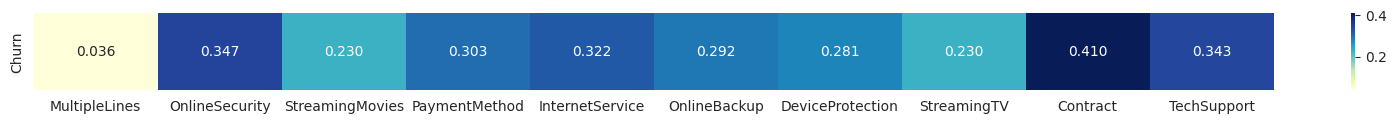

In [ ]:
printmd("**Cramers V Heatmap on Polytomous Features and Target: Churn**")
cramers_v_val = pd.DataFrame(index=['Churn'], columns=polytomous_cols)

for j in range(0,len(polytomous_cols)):
    u = cramers_v(df_churn['Churn'], df_churn[polytomous_cols[j]])
    cramers_v_val.loc[:,polytomous_cols[j]] = u

# Convert all values in the DataFrame to numeric, coercing errors to NaN
cramers_v_val = cramers_v_val.apply(pd.to_numeric, errors='coerce')

cramers_v_val.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(cramers_v_val,annot=True,fmt='.3f', cmap="YlGnBu")
plt.show()

#### Using Scipy Module

In [ ]:
crosstab = pd.crosstab(df_churn['OnlineSecurity'], df_churn['Churn'])
display(crosstab)
printmd(f"Association between OnlineSecurity and Target:Churn **{stats.contingency.association(crosstab, method='cramer')}**")

Churn                  No   Yes
OnlineSecurity                 
No                   2037  1461
No internet service  1413   113
Yes                  1724   295

Association between OnlineSecurity and Target:Churn **0.3474004326740552**

<a id='6.5.3'></a>
### 6.5.3 Uncertainty Coefficient
---


AKA **Theil’s U** - an **asymmetric** measure of association between categorical features

It is is based on the conditional entropy between x and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur.

Formaly marked as U(x|y); Just like Cramer’s V, the output value is on the range of [0,1], where 0 means that feature y provides no information about feature x, and 1 means that feature y provides full information about features x's value

**Unlike Cramer’s V, it is asymmetric**

So we will not lose any valuable information unlike symmetric tests

In [ ]:
def conditional_entropy(x,y):
  # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1  # Return a numeric value (1) when s_x is zero
    else:
        return (s_x - s_xy) / s_x

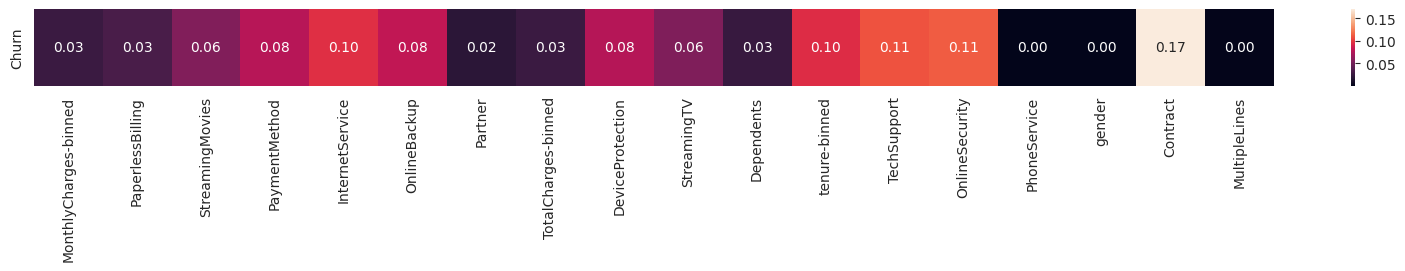

In [ ]:
theilu = pd.DataFrame(index=['Churn'], columns=cat_cols)

for j in range(0,len(cat_cols)):
    u = theil_u(df_churn['Churn'].tolist(),df_churn[cat_cols[j]].tolist())
    theilu.loc[:,cat_cols[j]] = u

# Convert all values in 'theilu' to numeric, coercing errors to NaN
theilu = theilu.apply(pd.to_numeric, errors='coerce')

theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

<a id='6.6'></a>
## 6.6 Collinearity

For categorical variables, multicollinearity can be detected with **Spearman rank correlation coefficient** (ordinal variables) and **chi-square** test (nominal variables)

Spearman's ρ was already performed in a previous section that can be used as a collinearity measure

That's why let's just proceed with **chi-square** here -

<a id='6.6.1'></a>
### 6.6.1 Chi-Square

In [ ]:
calculate_chi_square('PaymentMethod','MultipleLines')

Correlation between **PaymentMethod** and **MultipleLines**

p-value : 1.1367151062832025e-81, degree of freedom: 6
probability=0.950, critical=12.592, stat=392.514
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



In [ ]:
calculate_chi_square('PaymentMethod','PhoneService')

Correlation between **PaymentMethod** and **PhoneService**

p-value : 0.8621473788722153, degree of freedom: 3
probability=0.950, critical=7.815, stat=0.747
Independent (fail to reject H0)
significance=0.050, p=0.862
Independent (fail to reject H0)
-----------------------------------



In [ ]:
calculate_chi_square('PaymentMethod','Contract')

Correlation between **PaymentMethod** and **Contract**

p-value : 4.067638353787387e-213, degree of freedom: 6
probability=0.950, critical=12.592, stat=1001.582
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------



<a id='6.7'></a>
## 6.7 Visualization

### Tenure and MonthlyCharges Distribution

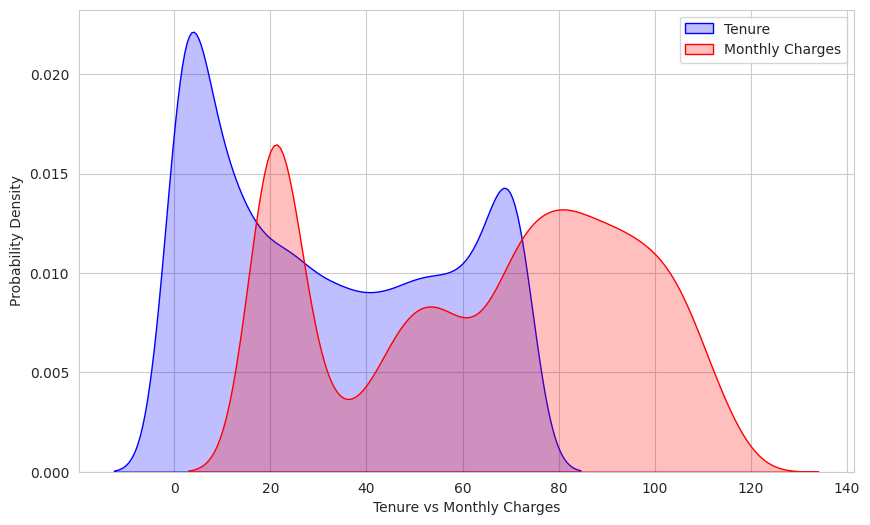

**Both are are not normally distributed, skewed,Tenure has a
Bi-modal distribution <br>Most users stayed for less than 20 months,
Monthly Charges for most people is nearly 20 unit**

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
sns.kdeplot(df_churn.tenure, color='b', shade=True, label='Tenure') # Change 'Label' to 'label'
sns.kdeplot(df_churn.MonthlyCharges, color='r', shade=True, label='Monthly Charges') # Change 'Label' to 'label'

plt.xlabel('Tenure vs Monthly Charges')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

printmd("""**Both are are not normally distributed, skewed,Tenure has a
Bi-modal distribution <br>Most users stayed for less than 20 months,
Monthly Charges for most people is nearly 20 unit**""")

In [ ]:
# https://stackoverflow.com/a/65242391/11105356

df_g = df_churn.groupby(['StreamingTV', 'Churn']).size().reset_index()
df_g['percentage'] = df_churn.groupby(['StreamingTV', 'Churn']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
df_g.columns = ['StreamingTV', 'Churn', 'Counts', 'Percentage']

fig = px.bar(df_g, x='StreamingTV', y='Counts',
       color='Churn',
       color_discrete_map={
        'Yes': '#99D594',
        'No': '#FC8D59',
    },
    text=df_g['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))

fig.show(renderer='colab')
printmd("**Similar ratio between streamer vs non-streamer in churned users**")

**Similar ratio between streamer vs non-streamer in churned users**

### Contract and Churn

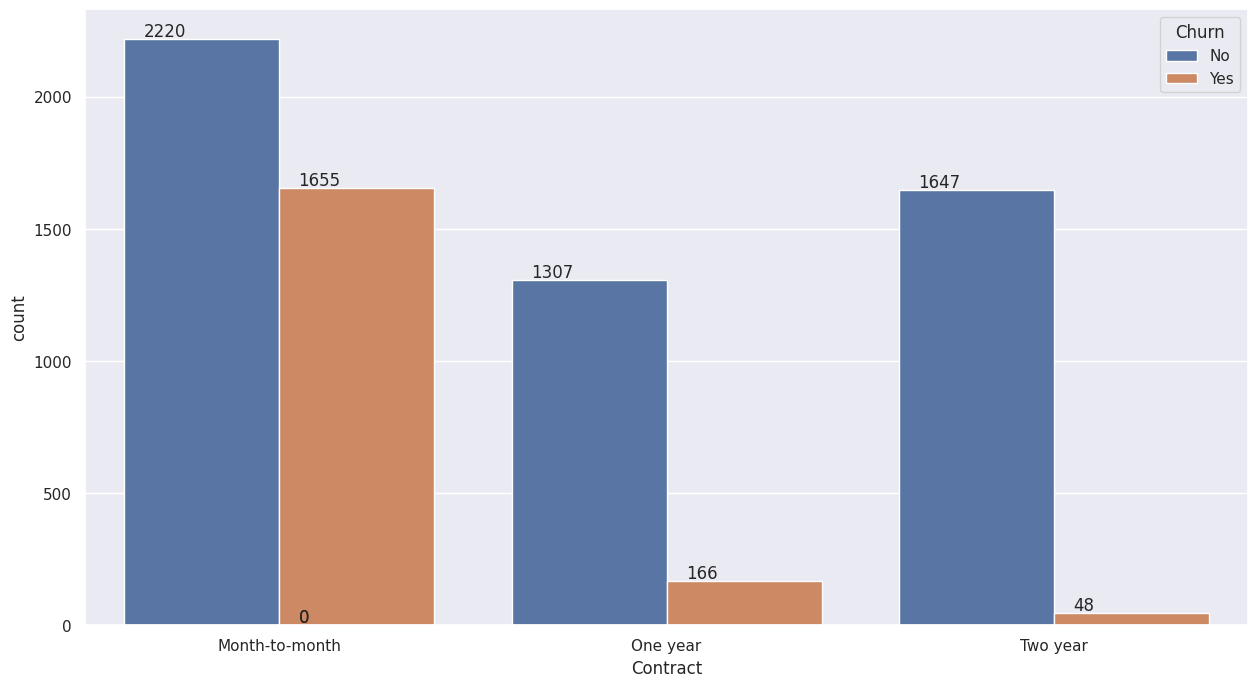

**Most churned users has Month-to-month contract**

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='Contract',hue='Churn',data=df_churn)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

printmd("**Most churned users has Month-to-month contract**")

### OnlineSecurity and Churn

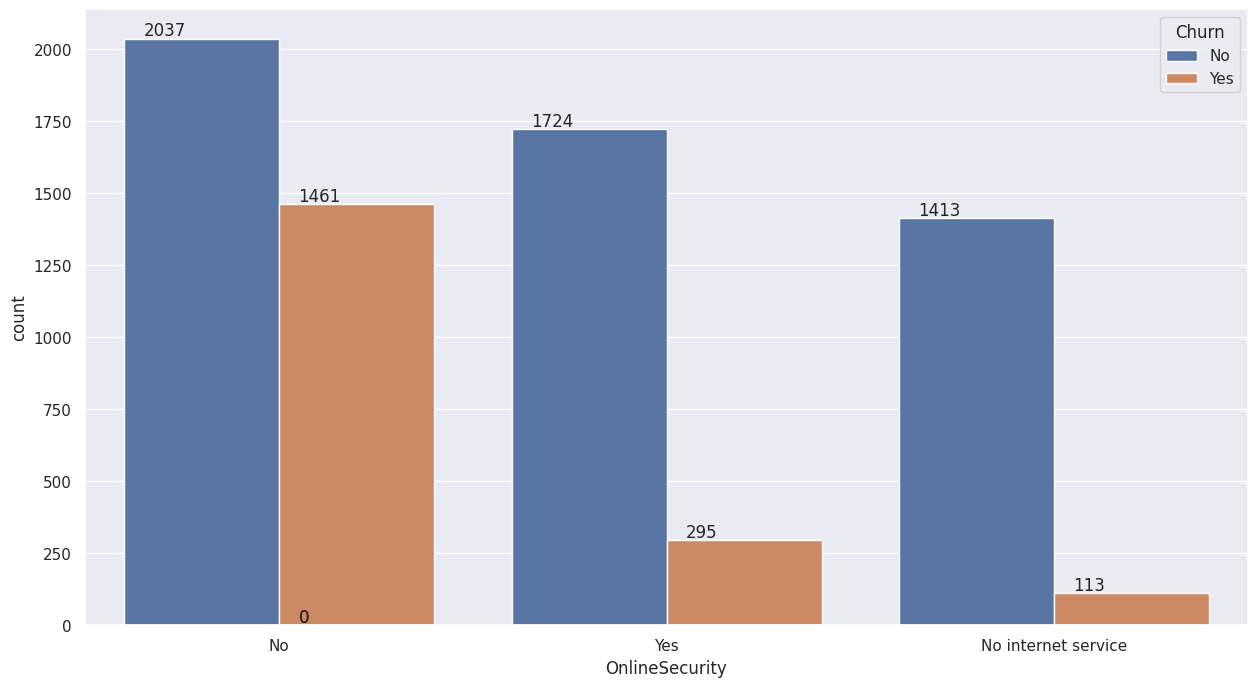

**Most churned users didn't have online security**

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='OnlineSecurity',hue='Churn',data=df_churn)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

printmd("**Most churned users didn't have online security**")

### Partner and Churn

**Most users who churned does not have a partner in contrast to the users who does**

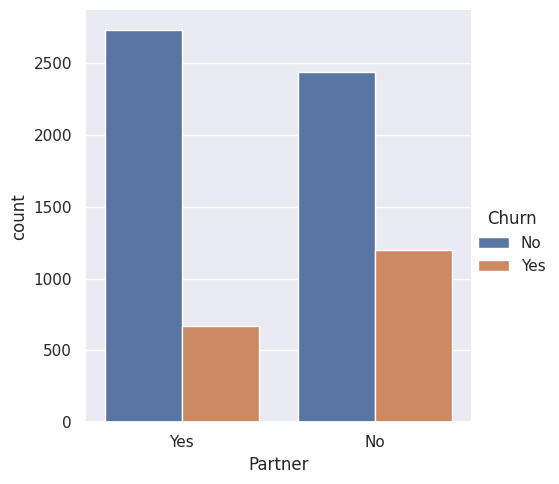

In [ ]:
sns.catplot(x='Partner',hue='Churn',data=df_churn, kind="count");

printmd("**Most users who churned does not have a partner in contrast to the users who does**")

### Gender, TotalCharges and Churn

**Gender is uncorrelated with churn rate**

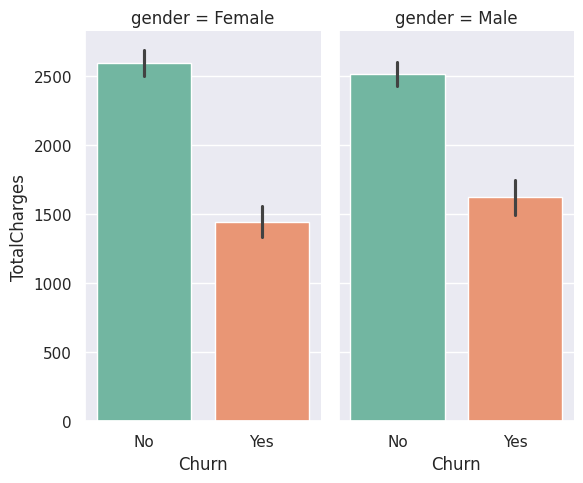

In [ ]:
sns.catplot(x='Churn',y='TotalCharges', col = 'gender', data=df_churn,
                kind='bar', aspect=.6, palette='Set2')

printmd("**Gender is uncorrelated with churn rate**")

### Checking Outliers

In [ ]:
fig1 = px.box(df_churn, x="Churn", y="MonthlyCharges")
fig1.show(renderer='colab')

In [ ]:
fig2 = px.box(df_churn, x="Churn", y="TotalCharges")
fig2.show(renderer='colab')

In [ ]:
fig3 = px.box(df_churn, x="Churn", y="tenure")
fig3.show(renderer='colab')

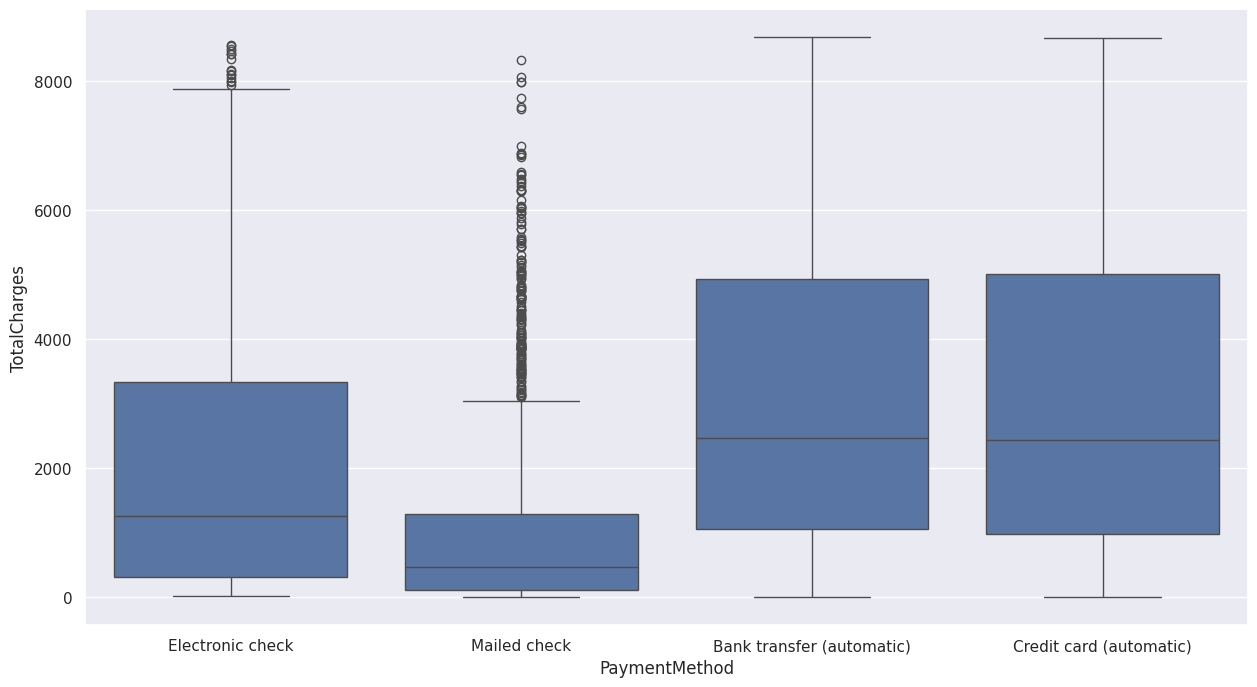

**Total Charges for many users are in extreme level in Mailed Check payment method**

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="PaymentMethod", y="TotalCharges", data=df_churn)
plt.show()

printmd("**Total Charges for many users are in extreme level in Mailed Check payment method**")

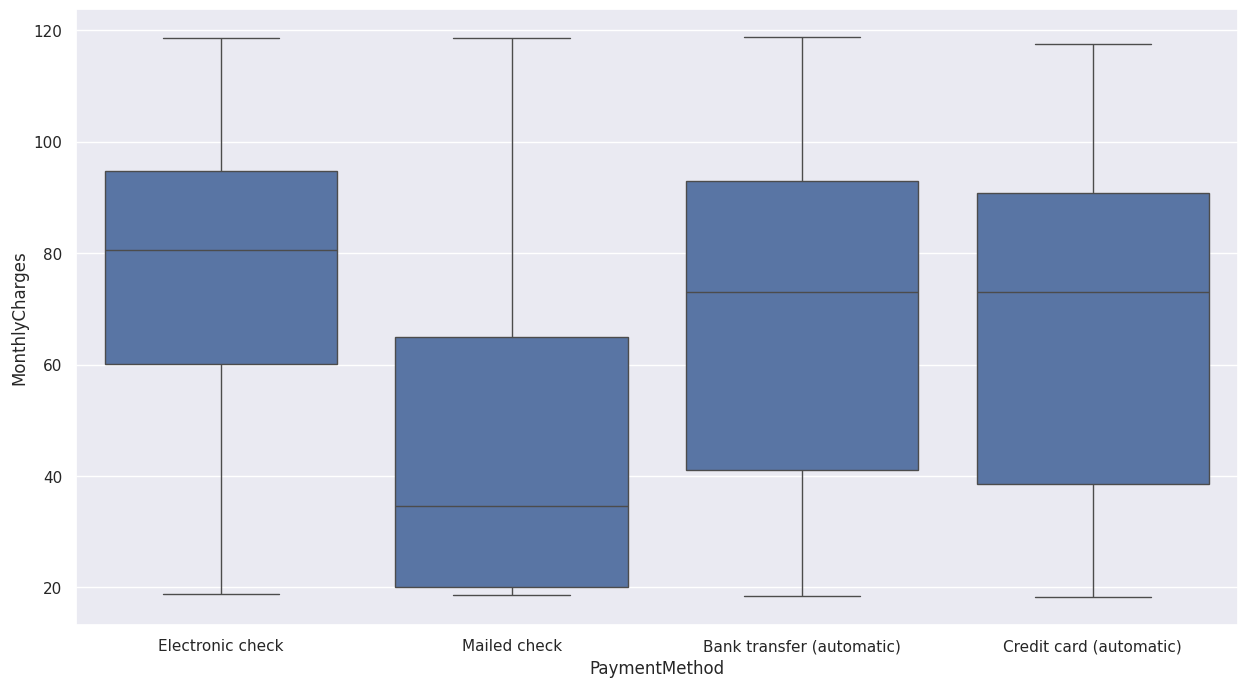

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="PaymentMethod", y="MonthlyCharges", data=df_churn)
plt.show()

<a id='7'></a>
# 7 Multivariate Analysis

<a id='7.1'></a>
### 7.1 Multicollinearity (Kruskal–Wallis)

For categorical and a continuous variable, multicollinearity can be measured by **t-test** (if the categorical variable has 2 categories, parametric) or **ANOVA** (more than 2 categories, parametric)

**Kruskal–Wallis test** is more commonly used when we have **three or more levels**. For two levels, the **Mann Whitney U Test** is appropriate

The **parametric equivalent of the Kruskal–Wallis test** is the one-way analysis of variance (ANOVA)

Hypothses -

* H0: All sample distributions are equal.
* H1: One or more sample distributions are not equal.


In [ ]:
# compare samples
stat, p = stats.kruskal(df_churn['TotalCharges'], df_churn['tenure'], df_churn['MonthlyCharges'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=13184.759, p=0.000
Different distributions (reject H0)


In [ ]:
# compare samples
stat, p = stats.kruskal(df_churn['DeviceProtection'], df_churn['StreamingMovies'], df_churn['PhoneService'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=4696.340, p=0.000
Different distributions (reject H0)


In [ ]:
# compare samples
stat, p = stats.kruskal(df_churn['Contract'], df_churn['PaymentMethod'], df_churn['PhoneService'], df_churn['InternetService'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=22407.812, p=0.000
Different distributions (reject H0)


<a id='7.2'></a>
## 7.2 Frequency Distribution

In [ ]:
def multivariate_analysis(cat_var_1, cat_var_2, cat_var_3, target_variable=df_churn.Churn):

    fig,ax = plt.subplots(1,1,figsize = (18,5))
    font_size = 15
    cat_grouped_by_cat_target = pd.crosstab(index = [cat_var_1, cat_var_2, cat_var_3],
                                        columns = target_variable, normalize = "index")*100
    cat_grouped_by_cat_target.rename({"Yes":"% Churn", "No":"% Not Churn"}, axis = 1, inplace = True)
    cat_grouped_by_cat_target.plot.bar(color = ["green", "red"],ax=ax)
    ax.set_xlabel(f"{cat_var_1.name}, {cat_var_2.name}, {cat_var_3.name}", fontsize = font_size)
    ax.set_ylabel("Relative Frequency(%)", fontsize = font_size)
    ax.tick_params(axis="x", labelsize=font_size)
    ax.tick_params(axis="y", labelsize=font_size)
    plt.legend(loc = "best")
    return plt.show()

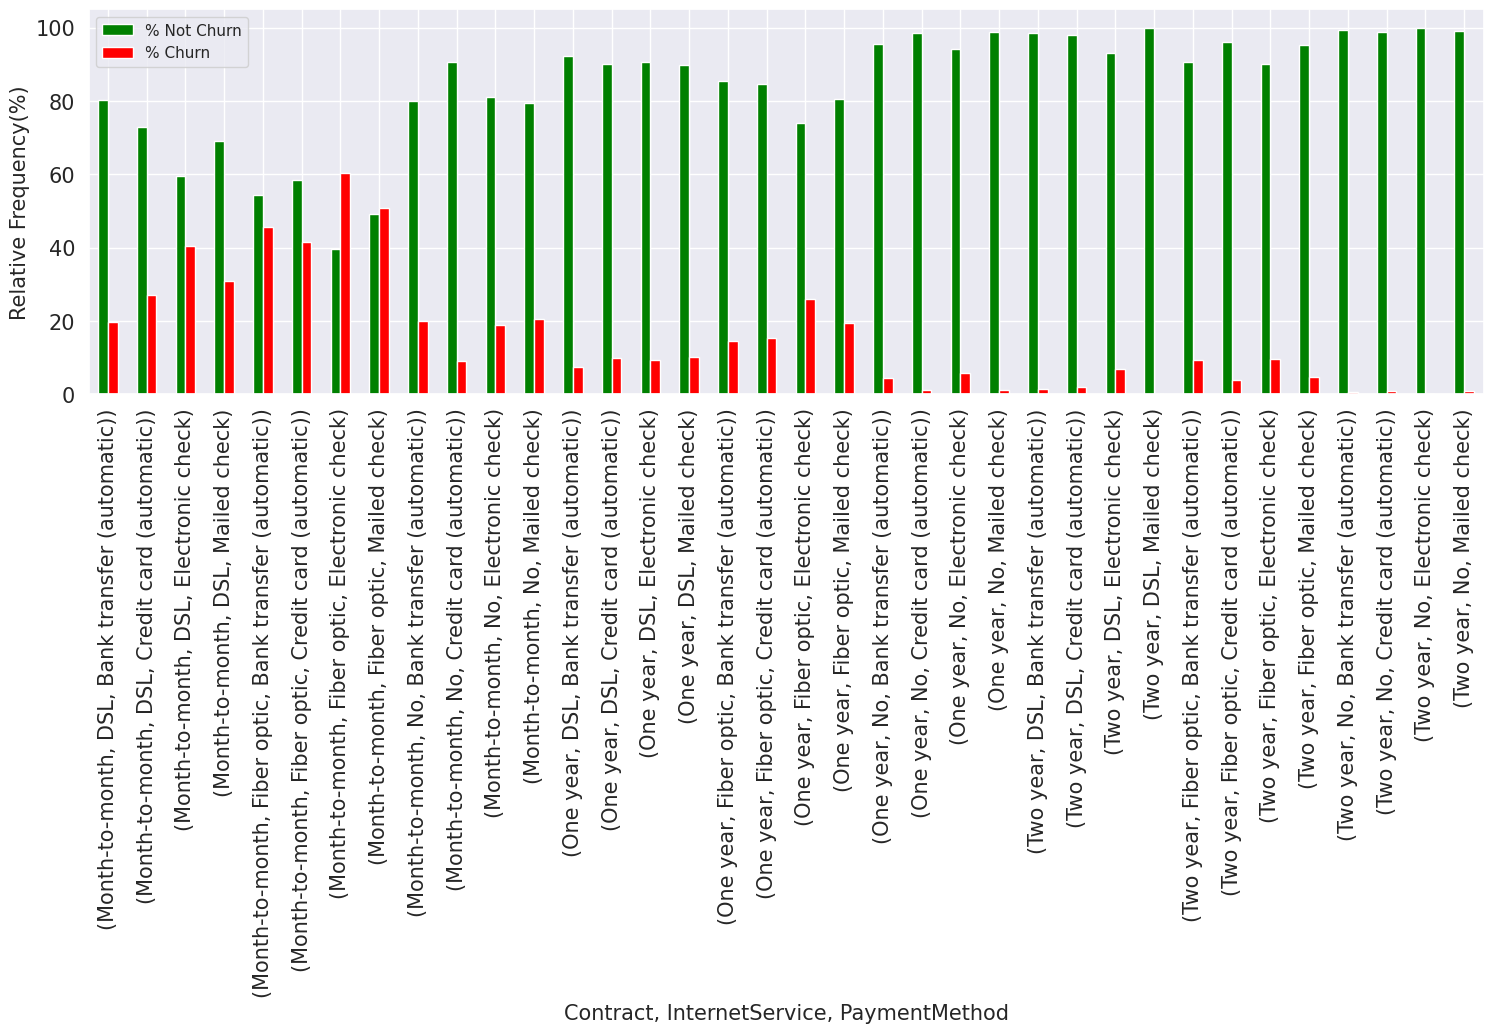

### Findings: Most of the users who churned had a Month-to-month contract and had internet service

In [ ]:
multivariate_analysis(df_churn.Contract, df_churn.InternetService, df_churn.PaymentMethod)
printmd("### Findings: Most of the users who churned had a Month-to-month contract and had internet service")

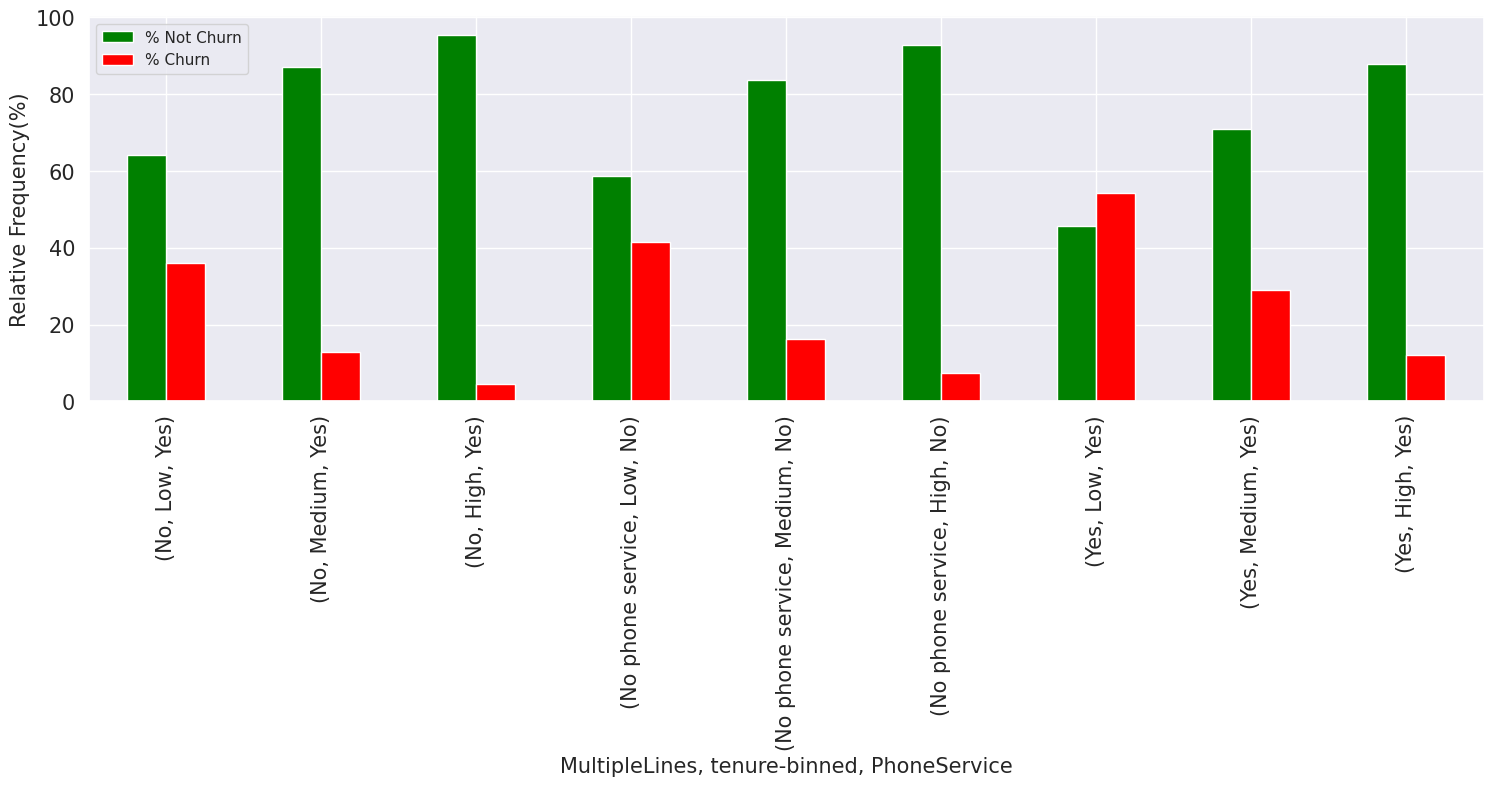

## Findings: Most of the users who churned had phone service

In [ ]:
multivariate_analysis(df_churn.MultipleLines, df_churn['tenure-binned'], df_churn.PhoneService)
printmd("## Findings: Most of the users who churned had phone service")

<a id='7.3'></a>
## 7.3 Churn Count Distribution

In [ ]:
def plot_counting_distribution(cardinality_value):

    #label encoding binary columns
    le = LabelEncoder()

    tmp_churn = df_churn[df_churn['Churn'] == 'Yes']
    tmp_no_churn = df_churn[df_churn['Churn'] == 'No']

    selected_columns = df_churn.nunique()[df_churn.nunique() == cardinality_value].keys()

    for col in selected_columns :
        tmp_churn[col] = le.fit_transform(tmp_churn[col])


    data_frame_x = tmp_churn[selected_columns].sum().reset_index()
    data_frame_x.columns = ["feature","Yes"]
    data_frame_x["No"] = tmp_churn.shape[0]  - data_frame_x["Yes"]
    data_frame_x = data_frame_x[data_frame_x["feature"] != "Churn"]

    #count of 1's(yes)
    trace1 = go.Scatterpolar(r=data_frame_x["Yes"].values.tolist(),
                          theta=data_frame_x["feature"].tolist(),
                          fill="toself", name="Churn 1's",
                          mode="markers+lines", visible=True,
                          marker=dict(size=5)
                          )

    #count of 0's(No)
    trace2 = go.Scatterpolar(r=data_frame_x["No"].values.tolist(),
                          theta=data_frame_x["feature"].tolist(),
                          fill="toself",name="Churn 0's",
                          mode="markers+lines", visible=True,
                          marker=dict(size = 5)
                          )
    for col in selected_columns :
        tmp_no_churn[col] = le.fit_transform(tmp_no_churn[col])

    data_frame_x = tmp_no_churn[selected_columns].sum().reset_index()
    data_frame_x.columns  = ["feature","Yes"]
    data_frame_x["No"]    = tmp_no_churn.shape[0]  - data_frame_x["Yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]

    #count of 1's(yes)
    trace3 = go.Scatterpolar(r = data_frame_x["Yes"].values.tolist(),
                          theta = data_frame_x["feature"].tolist(),
                          fill  = "toself",name = "NoChurn 1's",
                          mode = "markers+lines", visible=False,
                          marker = dict(size = 5)
                          )

    #count of 0's(No)
    trace4 = go.Scatterpolar(r = data_frame_x["No"].values.tolist(),
                          theta = data_frame_x["feature"].tolist(),
                          fill  = "toself",name = "NoChurn 0's",
                          mode = "markers+lines", visible=False,
                          marker = dict(size = 5)
                          )

    data = [trace1, trace2, trace3, trace4]

    updatemenus = list([
      dict(active=0,
          x=-0.15,
          buttons=list([
              dict(
                  label = 'Churn Dist',
                  method = 'update',
                  args = [{'visible': [True, True, False, False]},
                      {'title': f'Customer Churn Binary Counting Distribution' }]),

              dict(
                    label = 'No-Churn Dist',
                  method = 'update',
                  args = [{'visible': [False, False, True, True]},
                      {'title': f'No Customer Churn Binary Counting Distribution'}]),

          ]),
      )
])

    layout = dict(title='ScatterPolar Distribution of Churn and', updatemenus=updatemenus)

    fig = go.Figure(data=data, layout=layout) # Create a plotly figure
    return fig # Return the figure object

<a id='7.3.1'></a>
###  7.3.1 Features With Cardinality = 2

In [ ]:
plot_counting_distribution(2)

<a id='7.3.2'></a>
###  7.3.2 Features With Cardinality = 3

In [ ]:
plot_counting_distribution(3)

<a id='8'></a>
# 8 Save Cleaned Dataset


##  Encode Target variable

In [ ]:
df_churn_cleaned = df_churn.copy()
df_churn_cleaned.Churn[df_churn_cleaned.Churn.str.lower() == 'yes'] = 1
df_churn_cleaned.Churn[df_churn_cleaned.Churn.str.lower() == 'no'] = 0

df_churn_cleaned['Churn'] = df_churn_cleaned['Churn'].astype('float')

In [ ]:
df_churn_cleaned.to_csv("Telco-Customer-Churn-dataset-cleaned.csv", index=False)

<a id='9'></a>
# 9 Conclusion

From the above analysis, we can conclude:

* Customer Churn is gender neutral, i.e., Gender has no correlation with the target
* Number of months the customer has stayed with the company (**tenure**) and the contract term of the customer (**contract**) are the most important features that have strong correlation with churn of the customer
* OnlineSecurity, TechSupport, InternetService, PaymentMethod are moderately correlated with customer churn

## What's Next ?

**Model building, hyperparameter optimization and deployment**

##### I applied XGBoost, Catboost and LightGBM and performed hyperparameter tuning using Optuna for all of the classifiers. Also I demonstrated how to save and load the model with their standard format.

##### Please visit this notebook to see the rest of the project -


### [Churn Prediction Part 2 : Triple Boost Stacking Ensemble + Optuna Tuning](https://www.kaggle.com/ahmedshahriarsakib/churn-prediction-part2-triple-boost-stack-optuna)


#### Also I deployed the project using [**streamlit**](https://streamlit.io)

#### Streamlit App Preview

![Telco Customer Churn Prediction Streamlit](https://user-images.githubusercontent.com/40615350/142819900-60053284-5266-4a66-87a3-cddcb2f0d929.gif "Telco Customer Churn Prediction Streamlit")

---

#### Please click the button below if you want to check the live app

[![Live in Streamlit](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://share.streamlit.io//ahmedshahriar/Telco-Customer-Churn-Prediction-Streamlit-App/main/app.py)

---

### If you like this project please feel free to fork the kernel,use the code, share the notebook and give an upvote. If you have any questions or suggestions to improve the analysis please comment below

In [ ]:
"""Import basic modules."""
import math
import os
import gc
import random
import pprint
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns

# Warning Libraries
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

"""Plotly visualization"""
from plotly.offline import init_notebook_mode

from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
                                   PowerTransformer) # convert to Gaussian-like data
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classic Algorithms
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Boosting Algorithms
import lightgbm as lgb
# from lightgbm                         import LGBMClassifier
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier


# optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import multiprocessing
import pickle, joblib

from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))


# customize as needed
plt_params = {
    # 'figure.facecolor': 'white',
    'axes.facecolor' : 'white',

    ## to set size
    # 'legend.fontsize': 'x-large',
    # 'figure.figsize': (15, 10),
    # 'axes.labelsize': 'x-large',
    # 'axes.titlesize': 'x-large',
    # 'xtick.labelsize': 'x-large',
    # 'ytick.labelsize': 'x-large'
}

plt.rcParams.update(plt_params)

sns.set_style('whitegrid')

init_notebook_mode(connected=True)
# pio.renderers.default='notebook' # to display plotly graph
%matplotlib inline

In [ ]:
# seed value
SEED = 42

# set optuna verbosity level
# default 20
# optuna_verbosity = optuna.logging.WARNING # https://optuna.readthedocs.io/en/latest/reference/logging.html#module-optuna.logging

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df_churn_cleaned, df_churn_cleaned["Churn"]):
    strat_train_set = df_churn_cleaned.loc[train_index]
    strat_test_set = df_churn_cleaned.loc[test_index]

print('Target Labels Ratio in Original Dataset\n')
print(df_churn_cleaned["Churn"].value_counts(normalize=True).sort_index())
# df_churn_cleaned["Churn"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["Churn"].value_counts(normalize=True).sort_index())
# strat_test_set["Churn"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

Churn
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64

Target Labels Ratio in Test Dataset

Churn
0.0    0.734564
1.0    0.265436
Name: proportion, dtype: float64


In [ ]:
# train Dataset
X = strat_train_set.drop("Churn", axis=1)
y = strat_train_set["Churn"].copy()

# test dataset
y_test = strat_test_set['Churn'].values
X_test = strat_test_set.drop('Churn',axis=1)

X.shape, y.shape, X_test.shape, y_test.shape

((5634, 22), (5634,), (1409, 22), (1409,))

In [ ]:
# Check cardinality of categorical variables :

# reinitiate cat_cols because 'customerID' is still included in cat_cols variable
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
num_cols = list(set(X._get_numeric_data().columns) - set({'SeniorCitizen'})) # already converted
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), cat_cols))
d = dict(zip(cat_cols, object_nunique))

print("Number of unique entries by column, in ascending order:\n")

sorted_cols_by_cardinality = sorted(d.items(), key=lambda x: x[1])
display(pd.DataFrame(sorted_cols_by_cardinality, columns=['Columns', 'Cardinality']))

print("Total Categorical Columns",len(cat_cols))
print("Total Numerical Columns",len(num_cols))

printmd("**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**")

Number of unique entries by column, in ascending order:



Columns  Cardinality
0        PaperlessBilling            2
1                 Partner            2
2              Dependents            2
3            PhoneService            2
4                  gender            2
5   MonthlyCharges-binned            3
6         StreamingMovies            3
7         InternetService            3
8            OnlineBackup            3
9     TotalCharges-binned            3
10       DeviceProtection            3
11            StreamingTV            3
12          tenure-binned            3
13            TechSupport            3
14         OnlineSecurity            3
15               Contract            3
16          MultipleLines            3
17          PaymentMethod            4

Total Categorical Columns 18
Total Numerical Columns 3


**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**

In [ ]:
ordinal_encoder = OrdinalEncoder()
X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

le = LabelEncoder()
y = le.fit_transform(y)

y_test = le.fit_transform(y_test)


num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

transformer = RobustScaler()
X[num_cols] = transformer.fit_transform(X[num_cols])
X_test[num_cols] = transformer.transform(X_test[num_cols])

### Correlation Heatmap

**Pearson’s R** (parametric) is not applicable when the data is categorical

**Kendall’s Tau** is a non-parametric measure of relationships between continuous or ordinal features

While Pearson's correlation assesses linear relationships, **Spearman's correlation** (non -parametric) assesses monotonic relationships (whether linear or not)


Most of the features in this dataset are categorical and nominal, so it's ineffective for those non-numerical attributes

Moreover, there are only **three numerical features** which are not normally distributed

Therefore, `pandas.corr()` is not feasible to use for this case


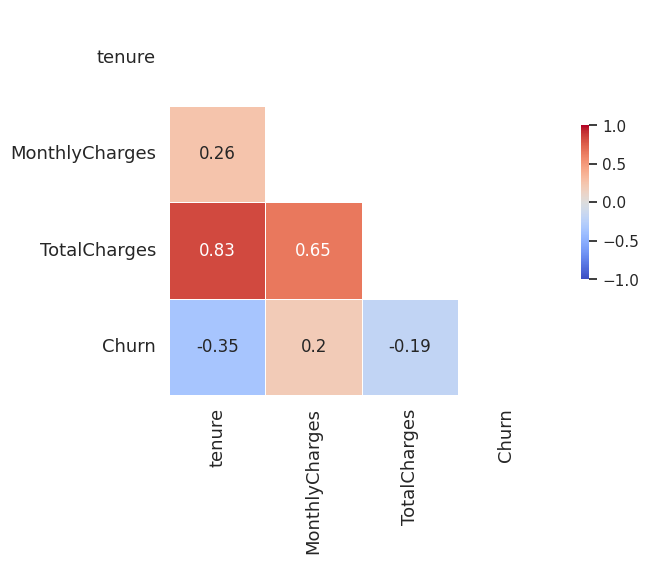

**Tenure is moderately correlated Numerical Feature with Target**

In [ ]:
# Correlation Matrix
# only numerical output
corr_matrix = pd.concat([X[num_cols],strat_train_set[["Churn"]]],axis=1).corr() # 'spearman' / 'pearson' / 'kendall'

# Set Up Mask To Hide Upper Triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)]= True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0, fontsize=13)
ax.set_xticklabels(corr_matrix.columns, fontsize=13)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.show()

printmd("**Tenure is moderately correlated Numerical Feature with Target**")

<a id='5'></a>
# 5 Modeling

<a id='5.1'></a>
## 5.1 Utility Function

<a id='5.1.1'></a>
### 5.1.1 Training

In [ ]:
def train_model(model, model_name, X, y, X_test, fold):
    printmd(f'**{model_name} Init**')
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    test_preds=None

    strat_kf = StratifiedKFold(n_splits=fold, random_state=SEED, shuffle=True)

    for fold, (train_index, valid_index) in enumerate(strat_kf.split(X, y)):
        X_train, X_valid = X.iloc[train_index] , X.iloc[valid_index]
        y_train, y_valid = y[train_index] , y[valid_index]


        #### to SMOTE sampling
        # sm = SMOTE(sampling_strategy='all', random_state=SEED)
        # X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        # X_val_oversampled, y_val_oversampled = sm.fit_resample(X_valid, y_valid)

        eval_set = [(X_valid, y_valid)]

        print("-" * 50)
        print(f"Fold {fold + 1}")

        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set= eval_set, verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc')


        val_pred = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, val_pred) # AUROC requires probabilities of the predictions

        # Convert probabilities to binary predictions for accuracy and other metrics
        val_pred_binary = (val_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_valid, val_pred_binary)  # Use binary predictions here
        precision = precision_score(y_valid, val_pred_binary)
        recall = recall_score(y_valid, val_pred_binary)
        f1 = f1_score(y_valid, val_pred_binary)

        print("AUC Score : ",auc)
        print("Accuracy Score : ", accuracy)
        print("Precision Score : ", precision)
        print("Recall Score : ", recall)
        print("F1 Score : ", f1)


        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)


        auc_scores.append(auc)

        if test_preds is None:
            test_preds = model.predict_proba(X_test)[:,1]
        else:
            test_preds += model.predict_proba(X_test)[:,1]


        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print("-" * 50)
    test_preds /= fold

    print(f'Train : Base Model - {model_name} - AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

    # evaluation on test set
    print(f'Test  : Base Model - {model_name} - AUC score : {roc_auc_score(y_test, test_preds)}')


    del test_preds
    gc.collect()

    print('Done!')

    if model_name == 'cat':
        plot_feature_importance(model.get_feature_importance(), X.columns, model_name)
        model.save_model("model_catboost")

    elif model_name == 'xgb':
        plot_feature_importance(model.feature_importances_, X.columns, model_name)

        # https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
        # save the model
        model.save_model('model_xgb.json')

    else:
        plot_feature_importance(model.feature_importances_, X.columns, model_name)
        model.booster_.save_model('model_lgbm.txt')
        joblib.dump(model, 'model_lgbm.pkl')

<a id='5.1.2'></a>
### 5.1.2 Model Interpretation

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8),dpi=100)
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# credit : https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

<a id='5.2'></a>
## 5.2 Catboost

<a id='5.1.1'></a>
### 5.2.1 Training

**cat Init**

--------------------------------------------------
Fold 1
AUC Score :  0.8276489533011271
Accuracy Score :  0.8014184397163121
Precision Score :  0.6610169491525424
Recall Score :  0.52
F1 Score :  0.582089552238806
--------------------------------------------------
Fold 2
AUC Score :  0.862157809983897
Accuracy Score :  0.8014184397163121
Precision Score :  0.6583333333333333
Recall Score :  0.5266666666666666
F1 Score :  0.5851851851851851
--------------------------------------------------
Fold 3
AUC Score :  0.8367069243156201
Accuracy Score :  0.7890070921985816
Precision Score :  0.628099173553719
Recall Score :  0.5066666666666667
F1 Score :  0.5608856088560885
--------------------------------------------------
Fold 4
AUC Score :  0.8323752012882448
Accuracy Score :  0.7890070921985816
Precision Score :  0.6448598130841121
Recall Score :  0.46
F1 Score :  0.5369649805447472
--------------------------------------------------
Fold 5
AUC Score :  0.842330512596051
Accuracy Score :  

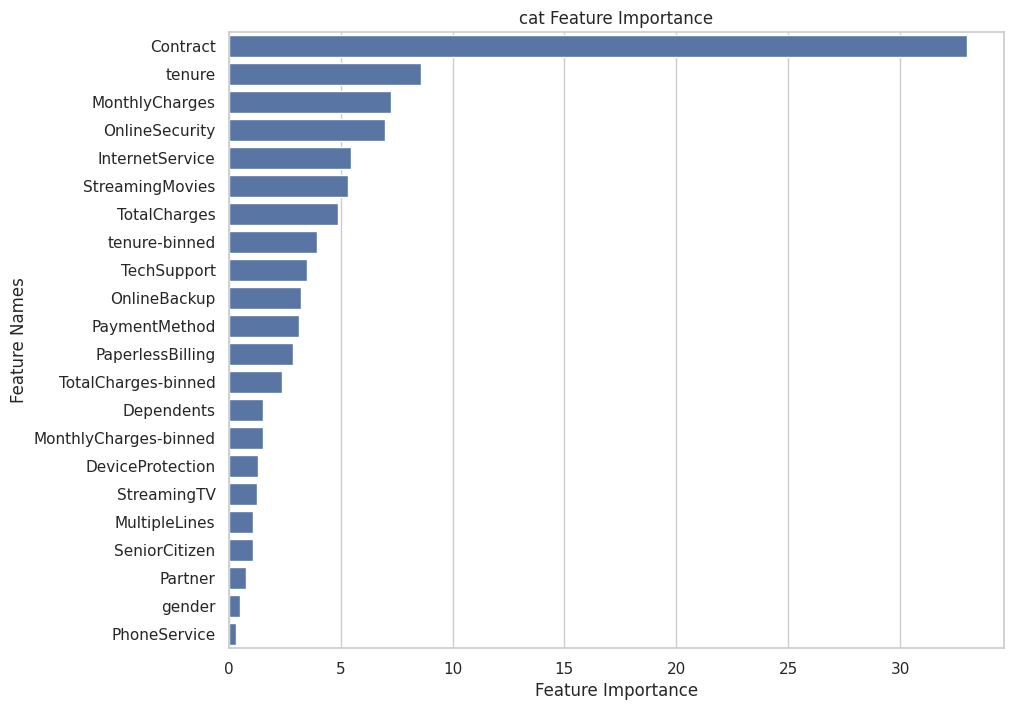

In [ ]:
%%time
# https://catboost.ai/en/docs/concepts/speed-up-training

# this dataset is fairly small, so catboost runs super slow on GPU
# https://github.com/catboost/catboost/issues/1034


fold_num = 10

# convert datatype to integer -> use 'cat_features' parameter
# it does not improve score, feel free to try it out
# for c in cat_cols:
#     X[c] = X[c].astype(np.int)
#     X_test[c] = X_test[c].astype(np.int)

cat_params  = {
    'eval_metric':"AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian',
    'colsample_bylevel': 0.013457968759952536, # does not support on gpu https://catboost.ai/en/docs/references/training-parameters/common#rsm
    'depth': 6,
    'iterations': 6888,
    'learning_rate': 0.05683590866750785,
    'random_strength': 18,
    'l2_leaf_reg': 50,
    'random_state': SEED,
#     'task_type':"GPU",
#     'devices' : '0',
    # 'cat_features':cat_cols
    }


cat = CatBoostClassifier(**cat_params)

train_model(cat, 'cat', X, y, X_test, fold_num)

<a id='5.2.2'></a>
### 5.2.2 Optuna Tuning

In [ ]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    # parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 6000, 8000),
        'depth' : trial.suggest_int('depth', 3, 12),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.1), #  # does not support on gpu
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]  # https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options
        ),
        'random_state': trial.suggest_categorical('random_state',[SEED]),
    }

    # learning
    model = CatBoostClassifier( # Make sure you are using CatBoostClassifier
        loss_function="Logloss",
        eval_metric="AUC",
        # task_type="GPU",  # Remove or comment out this line if you don't have a GPU
        l2_leaf_reg=50,
#         border_count=64,
        **params
    )
    model.fit(X_train, y_train,
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial

    return auc

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count()) # Make sure this line completes before the next cell

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[I 2024-06-14 04:47:51,234] A new study created in memory with name: no-name-29e309ea-9743-479e-b39e-82685813ae53
[I 2024-06-14 04:48:02,059] Trial 0 finished with value: 0.8335193365883903 and parameters: {'iterations': 7498, 'depth': 5, 'learning_rate': 0.04139089555182349, 'objective': 'Logloss', 'colsample_bylevel': 0.032522932251885205, 'random_strength': 87, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_state': 42}. Best is trial 0 with value: 0.8335193365883903.
[I 2024-06-14 04:48:05,522] Trial 1 finished with value: 0.8366284326642381 and parameters: {'iterations': 7714, 'depth': 8, 'learning_rate': 0.005026477678329182, 'objective': 'Logloss', 'colsample_bylevel': 0.05748633918487311, 'random_strength': 55, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_state': 42}. Best is trial 1 with value: 0.8366284326642381.
[I 2024-06-14 04:48:14,010] Trial 2 finished with value: 0.8307770802655712 and parameters: {'iterations': 6018, 'depth': 4, 'lea

**BEST TRIAL**

Best Score:  0.8402232039060683


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.0780307155594568,
 'depth': 3,
 'iterations': 6934,
 'learning_rate': 0.004591304571865085,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 29}
CPU times: user 40min 56s, sys: 2min 22s, total: 43min 19s
Wall time: 27min 16s


In [ ]:
# Save
pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

Best Score:  0.8402232039060683


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.0780307155594568,
 'depth': 3,
 'iterations': 6934,
 'learning_rate': 0.004591304571865085,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 29}



<a id='5.3'></a>
## 5.3 XGBoost

<a id='5.1.1'></a>
### 5.3.1 Training

**xgb Init**

--------------------------------------------------
Fold 1
AUC Score :  0.8275201288244767
Accuracy Score :  0.7340425531914894
Precision Score :  0.0
Recall Score :  0.0
F1 Score :  0.0
--------------------------------------------------
Fold 2
AUC Score :  0.8639613526570048
Accuracy Score :  0.8049645390070922
Precision Score :  0.6886792452830188
Recall Score :  0.4866666666666667
F1 Score :  0.5703124999999999
--------------------------------------------------
Fold 3
AUC Score :  0.831062801932367
Accuracy Score :  0.7340425531914894
Precision Score :  0.0
Recall Score :  0.0
F1 Score :  0.0
--------------------------------------------------
Fold 4
AUC Score :  0.827415458937198
Accuracy Score :  0.7304964539007093
Precision Score :  0.0
Recall Score :  0.0
F1 Score :  0.0
--------------------------------------------------
Fold 5
AUC Score :  0.842354829296761
Accuracy Score :  0.8134991119005328
Precision Score :  0.6864406779661016
Recall Score :  0.5436241610738255
F1 Score :  0.

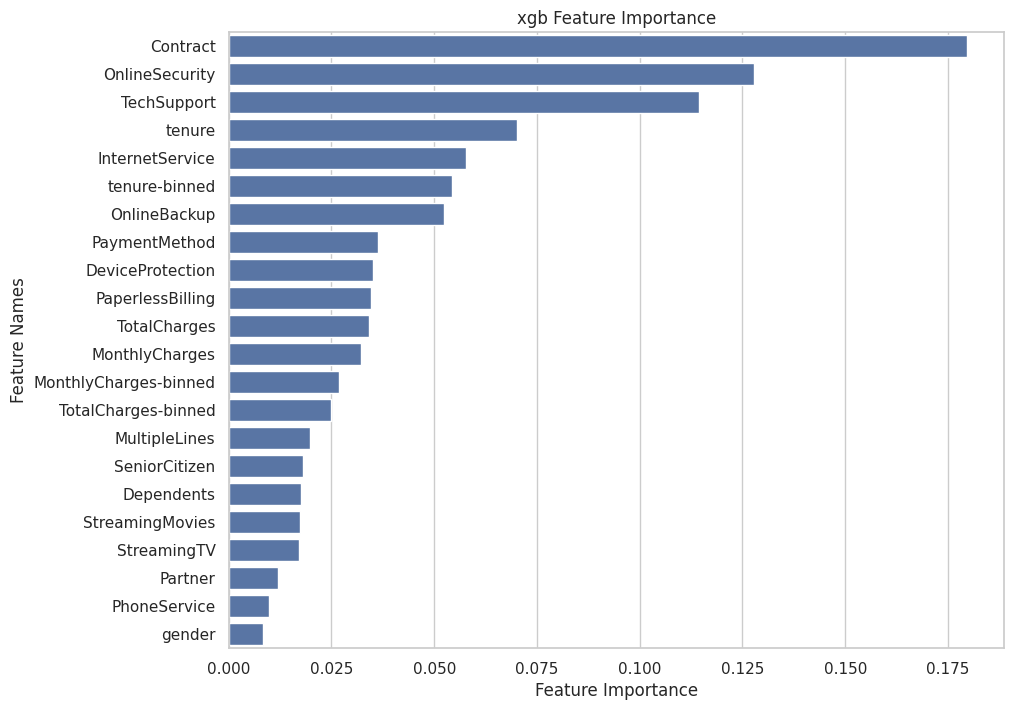

In [ ]:
%%time
fold_num = 10


# https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x

# Removed 'eval_metric' from xgb_params since it's already being passed to fit
xgb_params = {'colsample_bytree': 0.2645340949128848,
              'tree_method': 'hist',  # Change to 'hist' for CPU training
              # 'gpu_id': 0,  # Remove this line if not using GPU
              # 'predictor': 'gpu_predictor',  # Remove this line if not using GPU
              'gamma': 0,
              'learning_rate': 0.001851851953410451,
              'max_depth': 3,
              'n_estimators': 6000,
              'random_state': SEED,
              'reg_lambda': 0.1,
              'subsample': 0.6905005604726816,
              'use_label_encoder': False }


xgb = XGBClassifier(**xgb_params)

train_model(xgb, 'xgb', X, y, X_test, fold_num)

<a id='5.3.2'></a>
### 5.3.2 Optuna Tuning

In [ ]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    params  = {
          'n_estimators': trial.suggest_categorical('n_estimators',[10000]),
          'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
          'max_depth': trial.suggest_int('max_depth',3,12),
          'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,0.99,log=True),
          'subsample': trial.suggest_float('subsample',0.2,0.99,log=True),
          'eval_metric': trial.suggest_categorical('eval_metric',['auc']),
          'use_label_encoder':trial.suggest_categorical('use_label_encoder',[False]),
          'gamma': trial.suggest_categorical('gamma',[0, 0.25, 0.5, 1.0]),
          'reg_lambda': trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
          'tree_method': trial.suggest_categorical('tree_method',['hist']),  # Change to 'hist' for CPU training
          # 'gpu_id': trial.suggest_categorical('gpu_id',[0]),  # Remove these lines if not using GPU
          # 'predictor' : trial.suggest_categorical('predictor',['gpu_predictor']),
          'random_state': trial.suggest_categorical('random_state',[SEED])
         }

    # learning
    model = XGBClassifier(**params)
    model.fit(X_train, y_train,
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial

    return auc

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [ ]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[I 2024-06-13 17:05:02,197] A new study created in memory with name: no-name-7319c386-5af5-48bf-9904-be4f756197e2
[I 2024-06-13 17:05:23,188] Trial 0 finished with value: 0.8300485675165983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.003793843377801868, 'max_depth': 6, 'colsample_bytree': 0.46964080410283815, 'subsample': 0.7500210948915939, 'eval_metric': 'auc', 'use_label_encoder': False, 'gamma': 1.0, 'reg_lambda': 1.0, 'tree_method': 'hist', 'random_state': 42}. Best is trial 0 with value: 0.8300485675165983.
[I 2024-06-13 17:05:27,487] Trial 1 finished with value: 0.7900552843008086 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01982850423249453, 'max_depth': 8, 'colsample_bytree': 0.26679051806412285, 'subsample': 0.2755837370746061, 'eval_metric': 'auc', 'use_label_encoder': False, 'gamma': 0.5, 'reg_lambda': 0.1, 'tree_method': 'hist', 'random_state': 42}. Best is trial 0 with value: 0.8300485675165983.
[I 2024-06-13 17:05:44,849] Trial 3 finished wi

**BEST TRIAL**

Best Score:  0.8396484021803714


**XGBoost Tuned Hyperparameters**

{'colsample_bytree': 0.28251525768527,
 'eval_metric': 'auc',
 'gamma': 0.25,
 'learning_rate': 0.0018924092165237137,
 'max_depth': 12,
 'n_estimators': 10000,
 'random_state': 42,
 'reg_lambda': 50.0,
 'subsample': 0.23545629289824038,
 'tree_method': 'hist',
 'use_label_encoder': False}
CPU times: user 34min 25s, sys: 7min 7s, total: 41min 33s
Wall time: 27min 13s


In [ ]:
# Save
pickle.dump(study.best_trial.params, open('XGB_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)


# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

Best Score:  0.8396484021803714


**XGBoost Tuned Hyperparameters**

{'colsample_bytree': 0.28251525768527,
 'eval_metric': 'auc',
 'gamma': 0.25,
 'learning_rate': 0.0018924092165237137,
 'max_depth': 12,
 'n_estimators': 10000,
 'random_state': 42,
 'reg_lambda': 50.0,
 'subsample': 0.23545629289824038,
 'tree_method': 'hist',
 'use_label_encoder': False}


<a id='5.4'></a>
## 5.4 LGBM

<a id='5.4.1'></a>
### 5.4.1 Training

**lgbm Init**

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

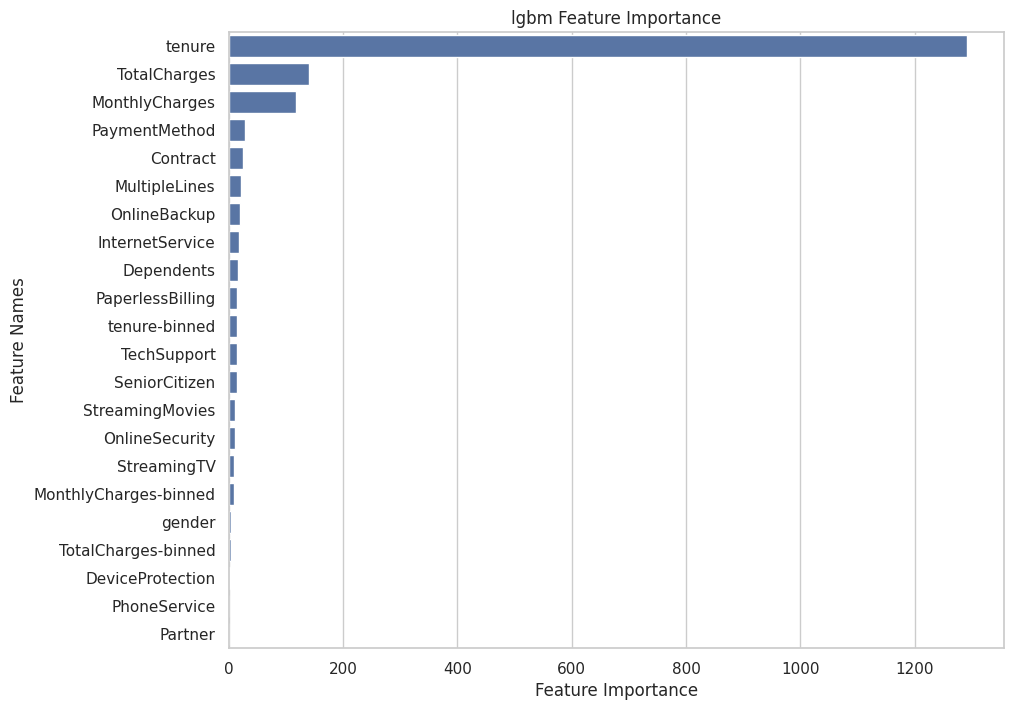

In [ ]:
# Remove or comment out the GPU-specific parameters
lgbm_params = {'n_estimators': 12749,
               'learning_rate': 0.1985328656822506,
               'reg_alpha': 9.77289653841389,
               'reg_lambda': 4.979048257991328,
               'num_leaves': 921,
               'min_child_samples': 85,
               'max_depth': 56,
               'colsample_bytree': 0.43848926369957975,
               'cat_smooth': 92,
               'cat_l2': 17,
               # 'device': 'gpu',  # Remove this line
               # 'gpu_platform_id': 0,  # Remove this line
               # 'gpu_device_id': 0,  # Remove this line
               'min_data_per_group': 59,
               'random_state': SEED

               }


lgbm = lgb.LGBMClassifier(**lgbm_params)

train_model(lgbm, 'lgbm', X, y, X_test, fold_num)

<a id='5.4.2'></a>
### 5.4.2 Optuna Tuning

In [ ]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    params = {
        'objective': 'binary', # binary target
        'n_estimators': trial.suggest_int('n_estimators', 4000, 20000),
        'learning_rate' : trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000), # num leaves = 2^max_depth
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'random_state': int(SEED),
        # Remove or comment out GPU specific parameters if you don't have a compatible GPU
        # 'device': 'gpu',
        # 'gpu_platform_id': 0,
        # 'gpu_device_id': 0,

        #     'subsample': 0.6,
        #     'subsample_freq': 1,
        #     'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
    }

    # Learning
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train) # Remove verbose parameter
    val_pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_pred) # AUROC requires probabilities of the predictions

    # print("AUC Score : ",auc) # check the auc score in each trial

    return auc

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:

%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**LGBM Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[I 2024-06-14 06:07:03,076] A new study created in memory with name: no-name-da9ee745-77c1-4a1d-87a9-ea7fe455f251
[I 2024-06-14 06:07:12,089] Trial 0 finished with value: 0.8383683381125837 and parameters: {'n_estimators': 10684, 'learning_rate': 0.036069817498183075, 'reg_alpha': 8.603619889314665, 'reg_lambda': 0.8847004344878916, 'num_leaves': 552, 'min_child_samples': 78, 'max_depth': 23, 'colsample_bytree': 0.4637132479483458, 'cat_smooth': 63, 'cat_l2': 18, 'min_data_per_group': 100}. Best is trial 0 with value: 0.8383683381125837.
[I 2024-06-14 06:07:15,665] Trial 1 finished with value: 0.8376785760417473 and parameters: {'n_estimators': 7920, 'learning_rate': 0.013749067245100461, 'reg_alpha': 4.537875190123454, 'reg_lambda': 0.06585979574297272, 'num_leaves': 527, 'min_child_samples': 69, 'max_depth': 16, 'colsample_bytree': 0.12153764015167307, 'cat_smooth': 56, 'cat_l2': 6, 'min_data_per_group': 135}. Best is trial 0 with value: 0.8383683381125837.
[I 2024-06-14 06:07:39,763

**BEST TRIAL**

Best Score:  0.8399377405771268


**LGBM Tuned Hyperparameters**

{'cat_l2': 20,
 'cat_smooth': 37,
 'colsample_bytree': 0.3240561241920765,
 'learning_rate': 0.021349830656171593,
 'max_depth': 54,
 'min_child_samples': 87,
 'min_data_per_group': 199,
 'n_estimators': 13667,
 'num_leaves': 385,
 'reg_alpha': 5.906121992931699,
 'reg_lambda': 5.558201607424332}
CPU times: user 27min 17s, sys: 1min 27s, total: 28min 45s
Wall time: 26min 26s


In [ ]:

# Save
pickle.dump(study.best_trial.params, open('LGBM_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)
printmd('**LGBM Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

Best Score:  0.8399377405771268


**LGBM Tuned Hyperparameters**

{'cat_l2': 20,
 'cat_smooth': 37,
 'colsample_bytree': 0.3240561241920765,
 'learning_rate': 0.021349830656171593,
 'max_depth': 54,
 'min_child_samples': 87,
 'min_data_per_group': 199,
 'n_estimators': 13667,
 'num_leaves': 385,
 'reg_alpha': 5.906121992931699,
 'reg_lambda': 5.558201607424332}


<a id='5.5'></a>
## 5.5 Stacking Ensemble

---
![image.png](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png)

In [ ]:
def stacking_data_loader(model, model_name, train, y, test, fold):
    '''
    input train, test datasets and fold value!
    returns train, test datasets for stacking ensemble
    '''

    stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = True)

    # Declaration Pred Datasets
    train_fold_pred = np.zeros((train.shape[0], 1))
    test_pred = np.zeros((test.shape[0], fold))

    for counter, (train_index, valid_index) in enumerate(stk.split(train, y)):
        X_train, y_train = train.iloc[train_index], y[train_index]
        X_valid, y_valid = train.iloc[valid_index], y[valid_index]

        print('------------ Fold', counter+1, 'Start! ------------')
        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        elif model_name == 'xgb':
            # Removed eval_metric from here as it's already in xgb_params
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric = 'auc')

        print('------------ Fold', counter+1, 'Done! ------------')

        train_fold_pred[valid_index, :] = model.predict_proba(X_valid)[:, 1].reshape(-1, 1)
        test_pred[:, counter] = model.predict_proba(test)[:, 1]
        del X_train, y_train, X_valid, y_valid
        gc.collect()

    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)

    del test_pred
    gc.collect()

    print('Done!')

    return train_fold_pred, test_pred_mean

# Thanks to : https://www.kaggle.com/junhyeok99/stacking-ensemble-tutorial

<a id='5.5.1'></a>
### 5.5.1 Level 0 : Base Models

In [ ]:
%%time
lgbm_params = {'n_estimators': 12749,
               'learning_rate': 0.1985328656822506,
               'reg_alpha': 9.77289653841389,
               'reg_lambda': 4.979048257991328,
               'num_leaves': 921,
               'min_child_samples': 85,
               'max_depth': 56,
               'colsample_bytree': 0.43848926369957975,
               'cat_smooth': 92,
               'cat_l2': 17,
               #'device': 'gpu',
               #'gpu_platform_id': 0,
               #'gpu_device_id': 0,
               'min_data_per_group': 59,
               'random_state': SEED,
              #  'is_unbalance':True,  # does not improve score
              # 'categorical_feature': cat_cols, # does not improve score
               }


lgbm = lgb.LGBMClassifier(**lgbm_params)


xgb_params = {'colsample_bytree': 0.2645340949128848,
            'eval_metric': 'auc',
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'predictor': 'gpu_predictor',
            'gamma': 0,
            'learning_rate': 0.001851851953410451,
            'max_depth': 3,
            'n_estimators': 6000,
            'random_state': SEED,
            'reg_lambda': 0.1,
            'subsample': 0.6905005604726816,
            'use_label_encoder': False }

xgb = XGBClassifier(**xgb_params)


cat_params  = {'eval_metric':"AUC",
              #  'task_type':"GPU",
              'loss_function': 'logloss',
              'boosting_type': 'Plain',
              'bootstrap_type': 'Bayesian', # 0.846998114133664
              'colsample_bylevel': 0.013457968759952536,
              'depth': 6,
              'iterations': 6888,
              'learning_rate': 0.05683590866750785,
              'objective': 'Logloss',
              'random_strength': 18,
              'l2_leaf_reg': 50,
              'random_state': SEED,
              # 'cat_features':cat_cols
              }


cat = CatBoostClassifier(**cat_params)

fold_num = 5

cat_train, cat_test = stacking_data_loader(cat, 'cat', X, y, X_test, fold_num)
del cat
gc.collect()

lgbm_train, lgbm_test = stacking_data_loader(lgbm, 'lgbm', X, y, X_test, fold_num)
del lgbm
gc.collect()

xgb_train, xgb_test = stacking_data_loader(xgb, 'xgb', X, y, X_test, fold_num)
del xgb
gc.collect()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

0


<a id='5.5.2'></a>
### 5.5.2 Stacking Datasets

In [ ]:
stack_X_train = np.concatenate((cat_train, lgbm_train, xgb_train), axis = 1)
stack_X_test = np.concatenate((cat_test, lgbm_test, xgb_test), axis = 1)

del cat_train, lgbm_train, xgb_train, cat_test, lgbm_test, xgb_test
gc.collect()

stack_X_train.shape, stack_X_test.shape

((5634, 3), (1409, 3))

<a id='5.5.3'></a>
### 5.5.3 Level 1 : Meta Model

Fold 1 AUC : 0.8444654484352027
Fold 2 AUC : 0.8323053495548769
Fold 3 AUC : 0.8484461086067892
Fold 4 AUC : 0.8650150259318502
Fold 5 AUC : 0.8613394911696788
AUC score : mean ---> 0.8503142847396795, std ---> 0.011829519712091195


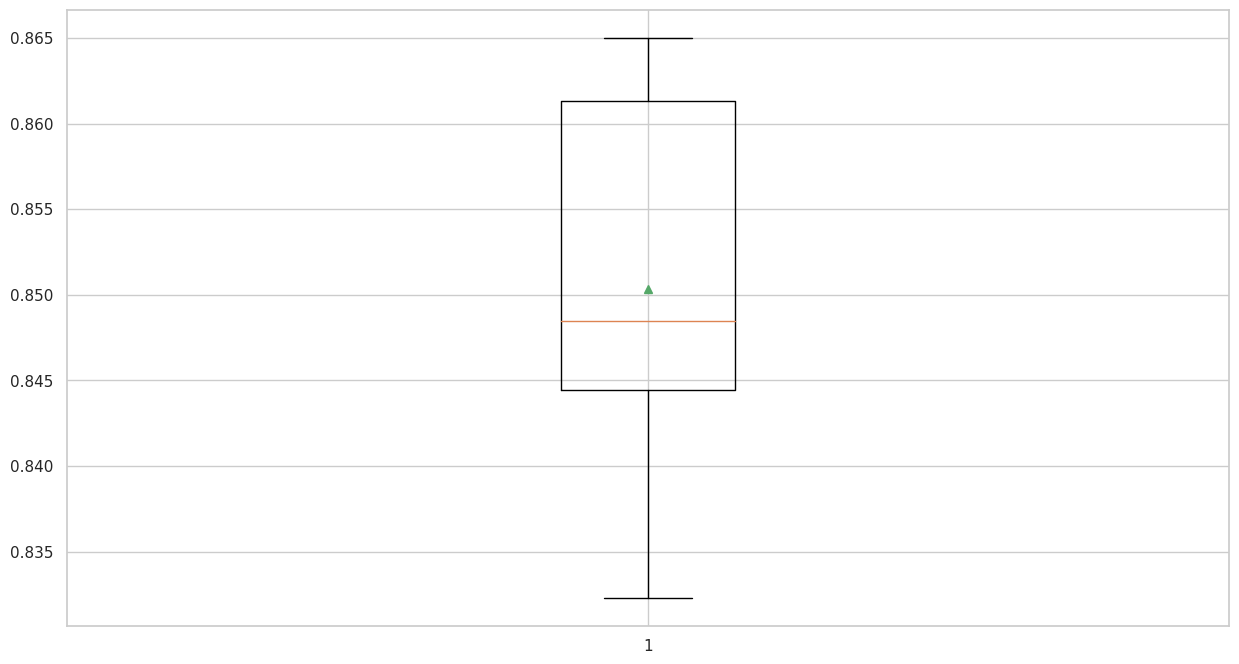

In [ ]:
# meta model : LogisticRegression
fold = 5
stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = True)
test_pred_log_reg = np.zeros((stack_X_test.shape[0], fold))
auc_scores = []

for counter, (train_index, valid_index)in enumerate(stk.split(stack_X_train, y)):
    X_train, y_train = stack_X_train[train_index], y[train_index]
    X_valid, y_valid = stack_X_train[valid_index], y[valid_index]

    #### to SMOTE sampling, not advised, low performance
    # sm = SMOTE(sampling_strategy='all', random_state=SEED)
    # X_train, y_train = sm.fit_resample(X_train, y_train)
    # X_valid, y_valid = sm.fit_resample(X_valid, y_valid)

    lr = LogisticRegression(n_jobs = -1, random_state = SEED, C = 0.3, max_iter = 10000)
    lr.fit(X_train, y_train)

    valid_pred_log_reg = lr.predict_proba(X_valid)[:, 1]
    test_pred_log_reg[:, counter] = lr.predict_proba(stack_X_test)[:, 1]

    auc = roc_auc_score(y_valid, valid_pred_log_reg)
    auc_scores.append(auc)

    print('Fold', counter+1 , 'AUC :', auc)
    fold += 1

test_pred_log_reg_mean = np.mean(test_pred_log_reg, axis = 1).reshape(-1, 1)

print(f'AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

plt.boxplot(auc_scores, showmeans=True)

plt.show()

# AUC score : mean ---> 0.8495059939911511, std ---> 0.014576136833225574

<a id='5.5.4'></a>
### 5.5.4 Stacking Model Evaluation

In [ ]:
roc_auc_score_log_reg = roc_auc_score(y_test, test_pred_log_reg_mean)

printmd(f"AUC on the test dataset : **{roc_auc_score_log_reg}**")

AUC on the test dataset : **0.848639851197396**

#### ROC Curve

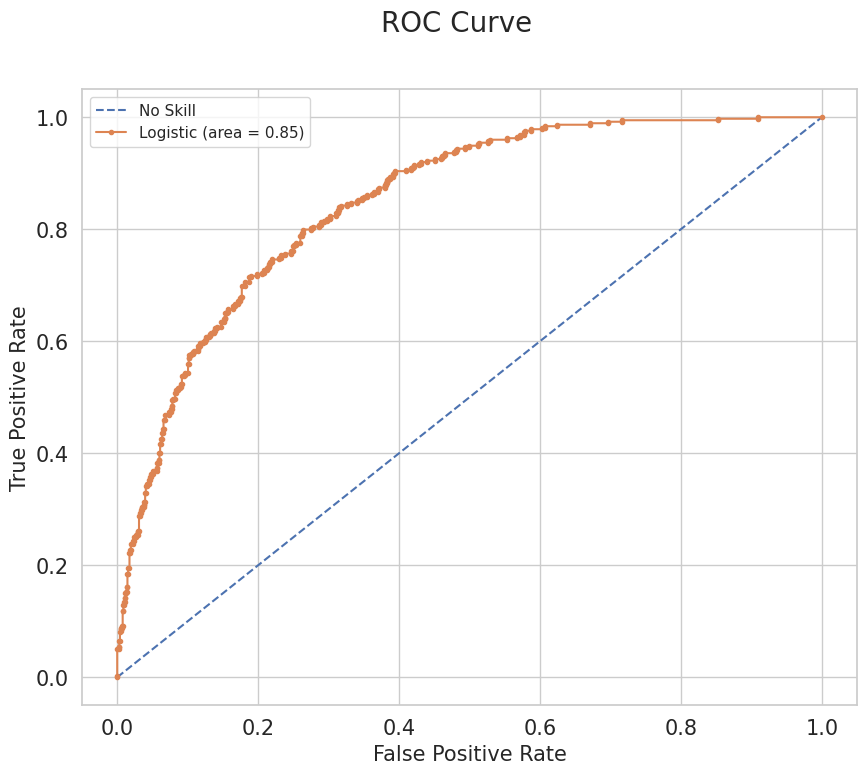

In [ ]:
plt.figure(figsize=(10,8))

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, test_pred_log_reg_mean)

# plot model roc curve
font_size = 15
plt.plot(fpr, tpr, marker='.', label=f'Logistic (area = {roc_auc_score_log_reg:0.2f})')

# axis labels
plt.xlabel('False Positive Rate', fontsize=font_size)
plt.ylabel('True Positive Rate', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
# curve title
plt.suptitle('ROC Curve', fontsize=20)
# show the legend
plt.legend()

# show the plot
plt.show()

#### PR Curve

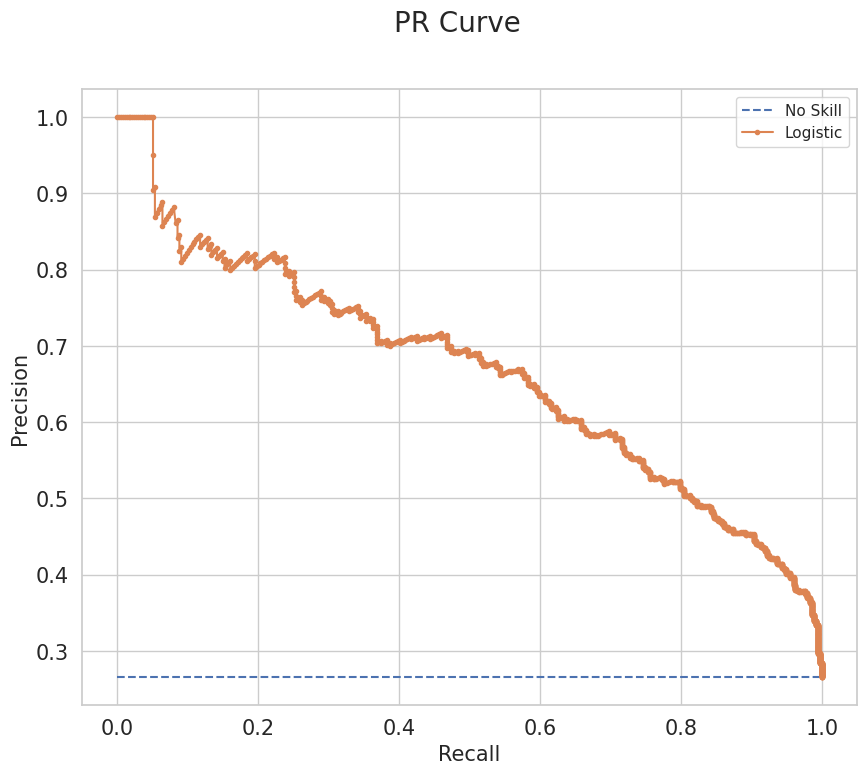

In [ ]:
plt.figure(figsize=(10,8))

# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)

# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, test_pred_log_reg_mean)

# plot the model precision-recall curve
font_size = 15
plt.plot(recall, precision, marker='.', label='Logistic')

# title PR curve
plt.suptitle('PR Curve', fontsize=20)

# axis labels
plt.xlabel('Recall', fontsize=font_size)
plt.ylabel('Precision', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
# show the legend
plt.legend()

# show the plot
plt.show()

<a id='5.5.5'></a>
### 5.5.5 Stacking Ensemble Classic ML Models

**Model Evaluation :**

>logreg, cross-validation score - mean  : 0.805 std: (0.019)
>knn, cross-validation score - mean  : 0.762 std: (0.015)
>rforest, cross-validation score - mean  : 0.792 std: (0.017)
>etree, cross-validation score - mean  : 0.781 std: (0.016)
>svm, cross-validation score - mean  : 0.797 std: (0.018)
>stacking, cross-validation score - mean  : 0.805 std: (0.020)


<br>

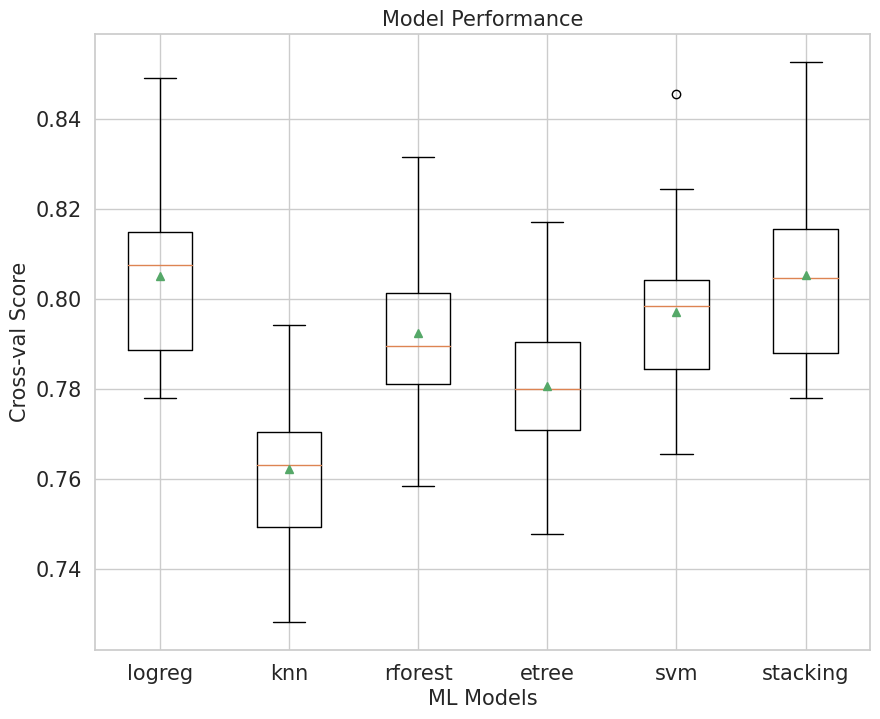

In [ ]:
# 5 fold stacking ensembling with 3 Repeated Stratified 10-Fold cross validation

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('logreg', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('rforest', RandomForestClassifier()))
    level0.append(('etree', ExtraTreesClassifier()))
    level0.append(('svm', SVC()))

    # define meta learner model
    level1 = LogisticRegression()

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['logreg'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['rforest'] = RandomForestClassifier()
    models['etree'] = ExtraTreesClassifier()
    models['svm'] = SVC()
    models['stacking'] = get_stacking()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

printmd("**Model Evaluation :**")

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s, cross-validation score - mean  : %.3f std: (%.3f)' % (name, np.mean(scores), np.std(scores)))

printmd("<br>")

# plot model performance for comparison
font_size = 15
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)

plt.title("Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("Cross-val Score",  fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.show()


# credit : https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python

**Classic ML models perform poorly in comparison with Gradient Boosting models**

<a id='6'></a>
# 6 Load Model

## Model Files

In [ ]:
import os
os.listdir('./')

['.config',
 'LGBM_Hyperparameter.pickle',
 'model_lgbm.txt',
 'model_lgbm.pkl',
 'CatBoost_Hyperparameter.pickle',
 'model_xgb.json',
 'catboost_info',
 'Telco-Customer-Churn-dataset-cleaned.csv',
 'model_catboost',
 'sample_data']

In [ ]:
def get_classifier(clf_name):
    if clf_name == 'XGBoost':
        clf = XGBClassifier()  # init model
        clf.load_model("./model_xgb.json")
    if clf_name == 'Catboost':
        clf = CatBoostClassifier()  # parameters not required.
        clf.load_model('./model_catboost')
    if clf_name == 'LGBM':
        clf = lgb.Booster(model_file='./model_lgbm.txt')
    return clf


models = ['XGBoost', 'Catboost', 'LGBM']
printmd("**Classifiers | Churn Predictions, Probability (Churn=True)**")
for model in models:

    clf = get_classifier(model)

    try:
        # xgboost,
        test_pred = clf.predict_proba(X_test[:3])[:, 1]  # probability of getting 1
        # check for first three instances of test dataset
    except AttributeError as ae:

        # lgbm load model
        # https://github.com/Microsoft/LightGBM/issues/1217

        test_pred = clf.predict(X_test[:3])
    print(model.ljust(12),'|' , test_pred)

**Classifiers | Churn Predictions, Probability (Churn=True)**

XGBoost      | [0.02915059 0.7101953  0.07856885]
Catboost     | [0.04617582 0.74236106 0.05992906]
LGBM         | [0.05037085 0.70955793 0.07904819]


<a id='7'></a>
# 7 Conclusion

* Number of months the customer has stayed with the company (**tenure**) and the contract term of the customer (**contract**) are the most important features that have strong correlation with churn of the customer
* Results from statiscial hypotheses testing reflects **similarity** with model feature importance
* With 80/20 train/test split triple boosting stacking ensemble model achieved an AUC of **~0.85**



<a id='8'></a>
# 8 Reference



1. [Statstest](https://www.statstest.com/relationship)
2. [Parametric nonparametric tests healthknowledge - healthknowledge.org](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1b-statistical-methods/parametric-nonparametric-tests)
3. [Feature Selection Method For Machine Learning - machinelearningmastery](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data)
4. [The Search for Categorical Correlation - towardsdatascience](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
5. [Nonparametric statistical significance](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)
6. [Eta-squared - ResearchGate](https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income)
7. [T-test examples - analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/07/t-test-performing-hypothesis-testing-with-python/)
8. [Nonparametric Statistical Hypothesis Tests - machinelearningmastery](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)
9. [Kendalls-tau](https://www.statstest.com/kendalls-tau/)
10. [Chi-Squared Test for Machine Learning](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)
11. [Parametric-and-non-parametric-data](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/parametric-and-non-parametric-data/)
12. [Mann-whitney-u-test for non-parametric](https://www.statisticshowto.com/mann-whitney-u-test/)
13. [Point-biserial correlation, Phi, & Cramer's V](http://web.pdx.edu/~newsomj/pa551/lectur15.htm)
14. [Theia's Uncertainity](https://en.wikipedia.org/wiki/Uncertainty_coefficient)
15. [Non-parametric-correlation-for-continuous-and-dichotomous-variables](https://stats.stackexchange.com/questions/86637/non-parametric-correlation-for-continuous-and-dichotomous-variables)
16. [Effect Size Wiki](https://en.wikipedia.org/wiki/Effect_size)
17. [Categorical correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
18. [Correlation_ratio dython](http://shakedzy.xyz/dython/modules/nominal/#correlation_ratio)
19. [Tetrachoric’s correlation](https://junye0798.com/post/everythin-you-need-to-know-about-correlation/)
20. [Chi-square](http://web.pdx.edu/~newsomj/pa551/lectur11.htm)
21. [Kruskal-wallis - statisticshowto](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/)
22. [Everything You Need To Know About Correlation](https://junye0798.com/post/everythin-you-need-to-know-about-correlation)
23. [Notes on XGBoost Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
24. [Understanding LightGBM Parameters (and How to Tune Them)](https://neptune.ai/blog/lightgbm-parameters-guide)
25. [Approaching (Almost) Any Machine Learning Problem - LinkedIn Article](https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur/)
26. [Parameter tuning - catboost.ai](https://catboost.ai/en/docs/concepts/parameter-tuning)